## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'approx1e5-pastis-fourier-blue' # Dataset Format: size-name-transform-channel

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/pastis/fourier/approx1e5/blue'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [4]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif path_dict['transform'] == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::1000] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 31800,
 3: 22260,
 4: 44520,
 5: 41340,
 6: 50880,
 7: 54060,
 8: 66780,
 9: 63600,
 10: 85860,
 11: 104940,
 12: 111300,
 13: 136740,
 14: 162180,
 15: 187620,
 16: 203520,
 17: 257580,
 18: 289380,
 19: 337080,
 20: 381600,
 21: 470640,
 22: 540600,
 23: 610560,
 24: 712320,
 25: 855420,
 26: 973080,
 27: 1154340,
 28: 1316520,
 29: 1376940,
 30: 960360,
 31: 674160,
 32: 419760,
 33: 162180}

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamm

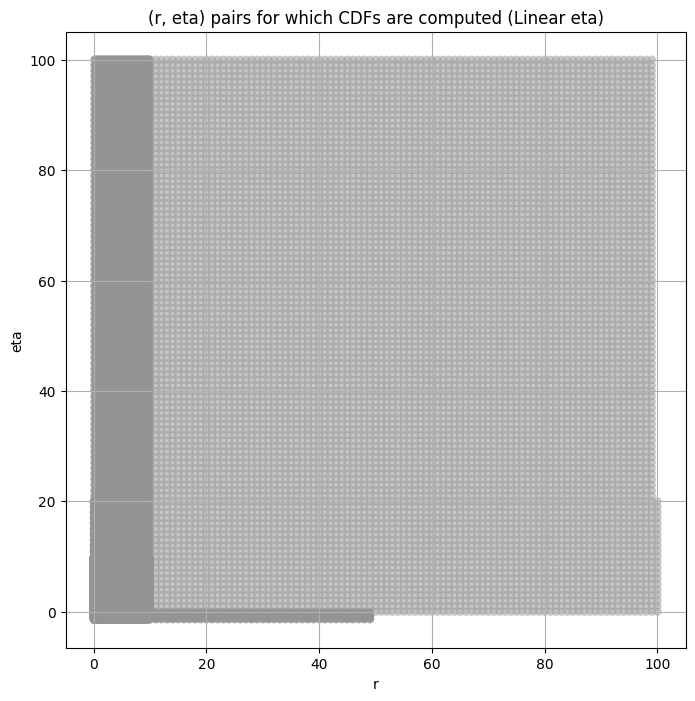

(r,eta),cdf     r  eta  \
0  ((0.02, -1.4), <scipy.interpolate._fitpack2.In...  0.02 -1.4   
1  ((0.02, -1.3), <scipy.interpolate._fitpack2.In...  0.02 -1.3   
2  ((0.02, -1.2), <scipy.interpolate._fitpack2.In...  0.02 -1.2   
3  ((0.02, -1.1), <scipy.interpolate._fitpack2.In...  0.02 -1.1   
4  ((0.02, -1.0), <scipy.interpolate._fitpack2.In...  0.02 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  9.618487e+69   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.821735e+74   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.455488e+78   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.406735e+81   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  5.331443e+83   

       kurtosis  
0  1.391529e+25  
1  8.172634e+21  
2  4.131785e+19  
3  6.947275e+17  
4  2.562075e+16

In [5]:
#warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [6]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [7]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [00:38<00:00, 2589.49it/s]


Band 5


100%|██████████| 100000/100000 [00:47<00:00, 2095.97it/s]


Band 8


100%|██████████| 100000/100000 [01:06<00:00, 1514.57it/s]


Band 11


100%|██████████| 100000/100000 [00:43<00:00, 2319.03it/s]


Band 14


100%|██████████| 100000/100000 [00:43<00:00, 2292.74it/s]


Band 17


100%|██████████| 100000/100000 [00:43<00:00, 2279.50it/s]


Band 20


100%|██████████| 100000/100000 [00:43<00:00, 2308.47it/s]


Band 23


100%|██████████| 100000/100000 [00:43<00:00, 2296.11it/s]


Band 26


100%|██████████| 100000/100000 [00:43<00:00, 2320.04it/s]


Band 29


100%|██████████| 100000/100000 [00:43<00:00, 2323.94it/s]


Band 32


100%|██████████| 100000/100000 [00:42<00:00, 2356.26it/s]


obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
band                                                                       
2     238621.340000  227525.050000  250164.660000   1.329861    0.962390   
5     125861.800000  119992.660000  131988.280000   1.392025    0.909872   
8      66732.330000   63640.670000   69916.100000   1.377129    0.967720   
11     36748.125000   34953.164000   38624.617000   1.727334    1.042835   
14     19290.611000   18380.465000   20250.715000   1.563712    0.985900   
17     10338.449000    9839.270500   10859.774000   1.652823    1.062084   
20      4938.306600    4692.662600    5208.717000   2.060602    1.170981   
23      2210.008000    2095.980200    2333.351800   2.336577    1.422220   
26       871.890900     814.146850     942.188800   5.787819    2.479208   
29       297.936550     265.633850     344.980260  23.688461    6.687737   
32        25.905695      24.708324      27.137707   1.305109    0.893868   

      kurt_upper  total_samples  
band                             
2       1.772640        31800.0  
5       2.123118        41340.0  
8       1.917665        66780.0  
11      3.028584       104940.0  
14      3.021425       162180.0  
17      3.063314       257580.0  
20      6.707925       381600.0  
23      4.876342       610560.0  
26     17.814651       973080.0  
29     80.945920      1376940.0  
32      2.017627       419760.0

## Initial Grid Search and Hypothesis Test Plots

####
Band  2


100%|██████████| 55966/55966 [01:11<00:00, 777.98it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 31800, Without approximation : 31800.0


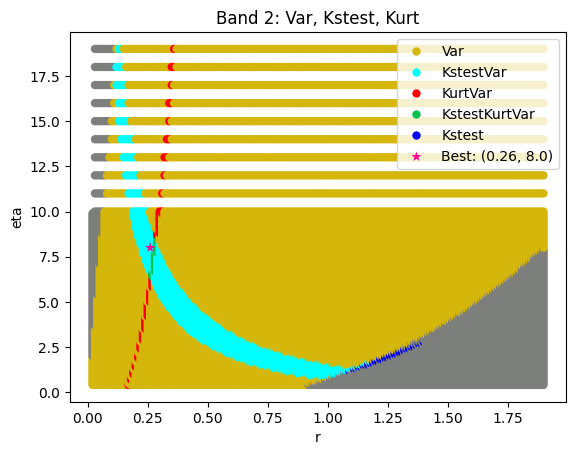

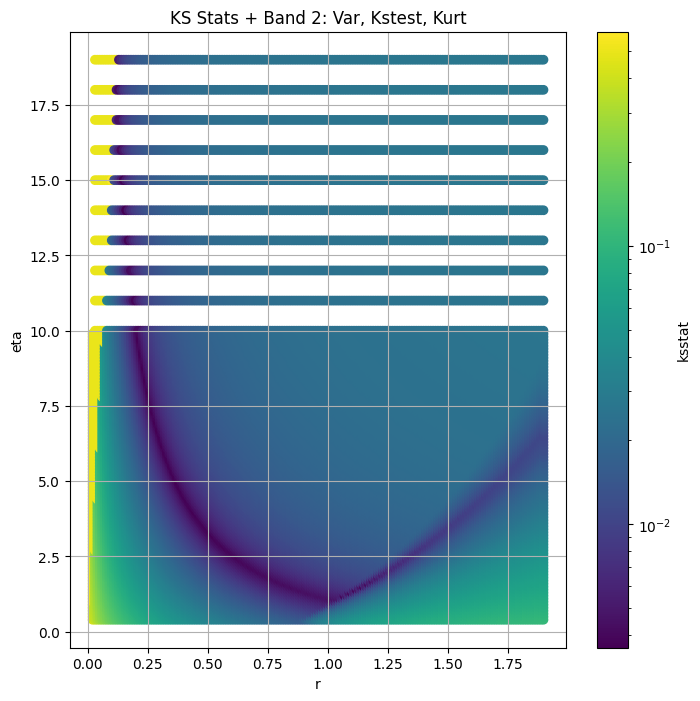

####
Band  5


100%|██████████| 55966/55966 [01:23<00:00, 670.90it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 41340, Without approximation : 41340.0


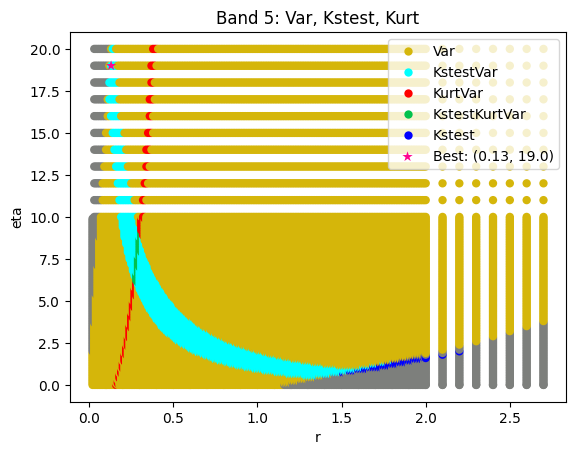

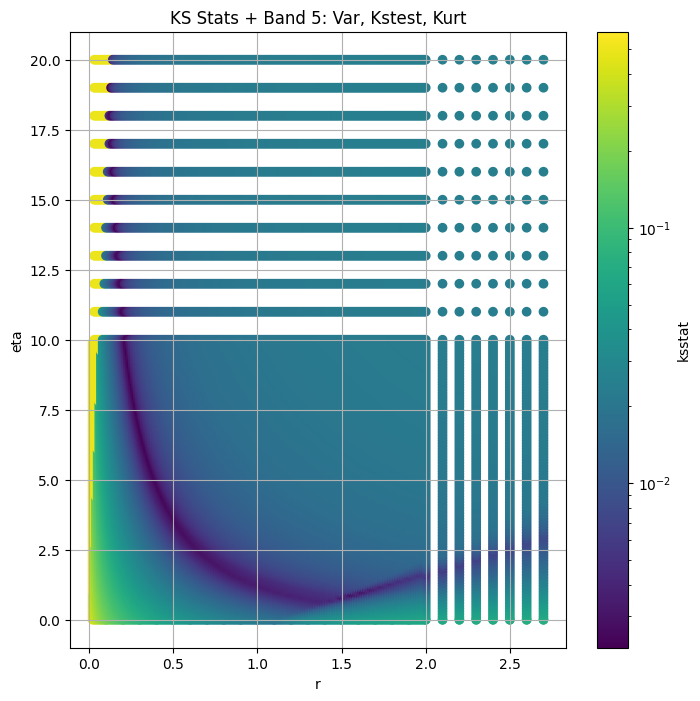

####
Band  8


100%|██████████| 55966/55966 [02:09<00:00, 431.17it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 66780, Without approximation : 66780.0


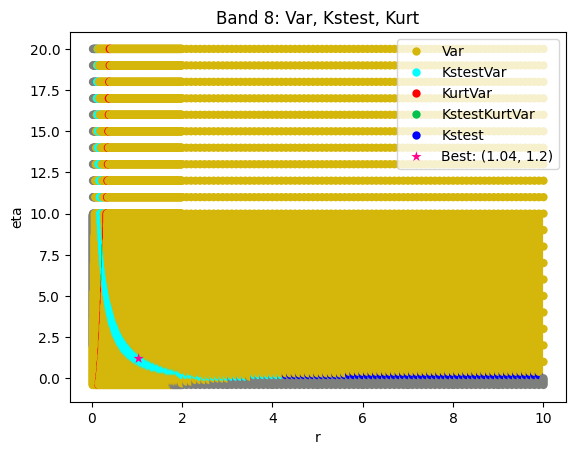

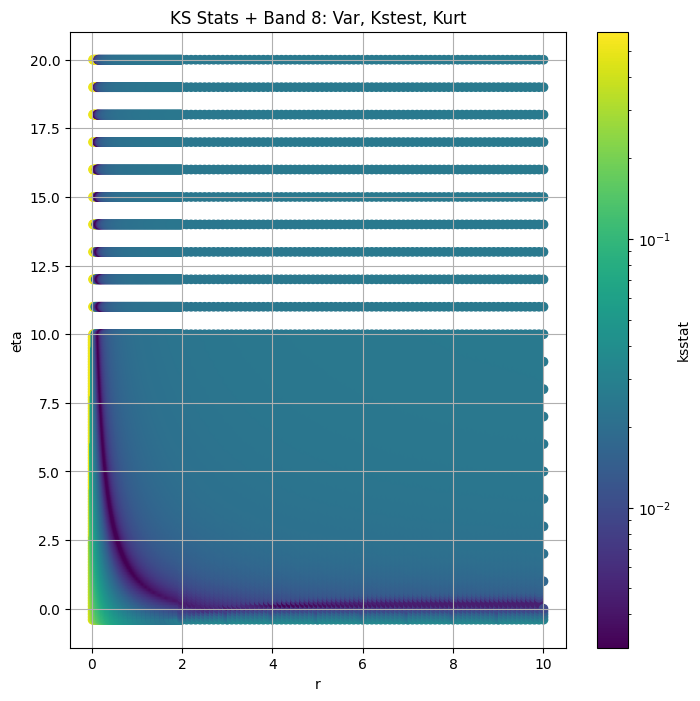

####
Band  11


100%|██████████| 55966/55966 [03:13<00:00, 288.78it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 104940.0


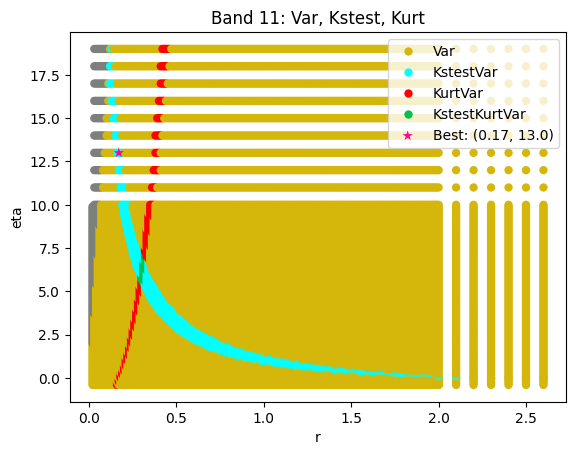

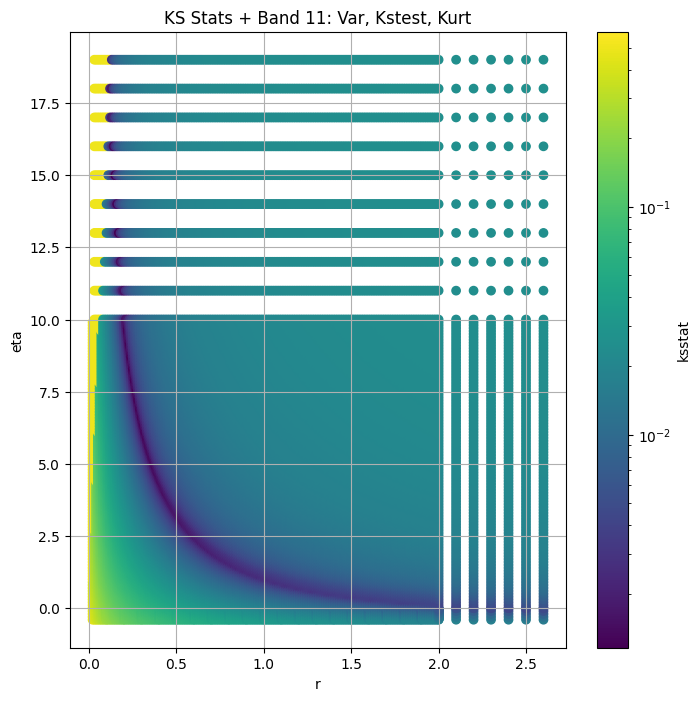

####
Band  14


100%|██████████| 55966/55966 [03:19<00:00, 280.53it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 162180.0


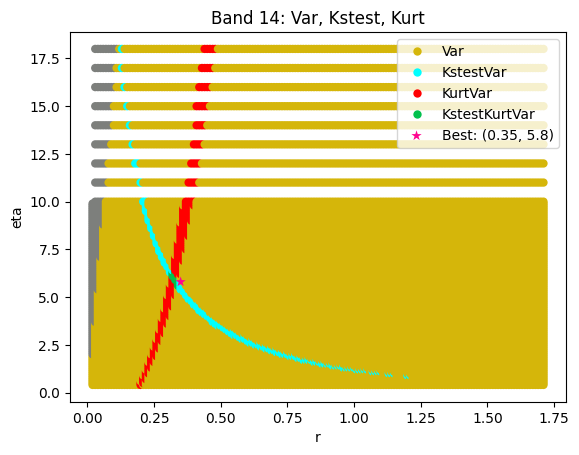

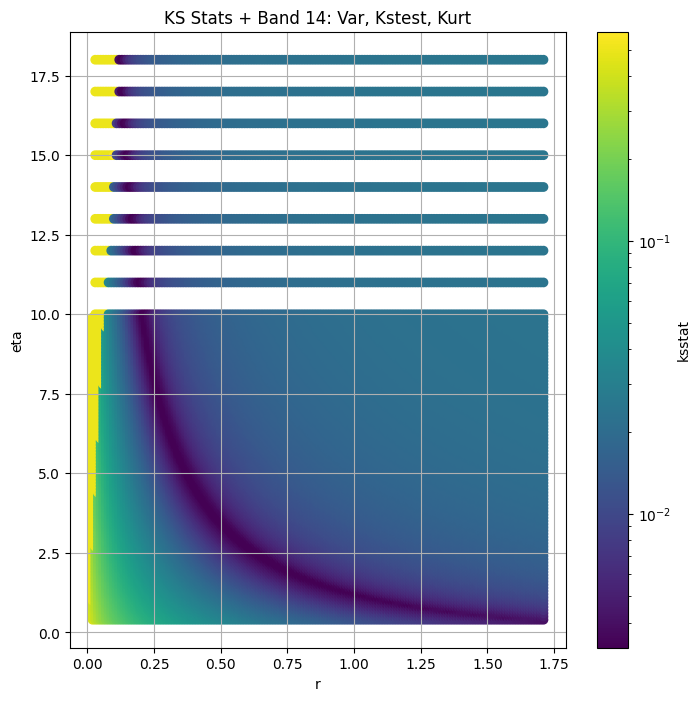

####
Band  17


100%|██████████| 55966/55966 [03:21<00:00, 277.84it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 257580.0


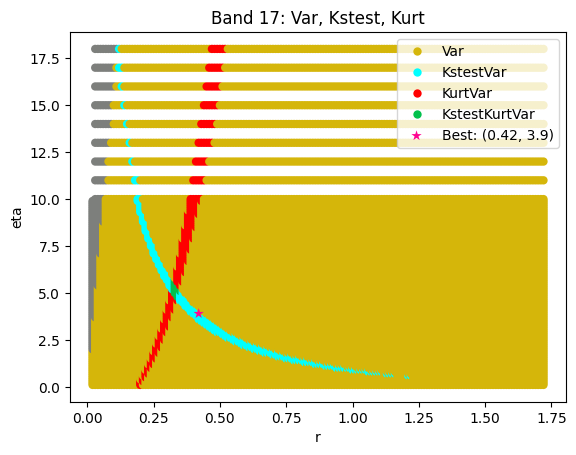

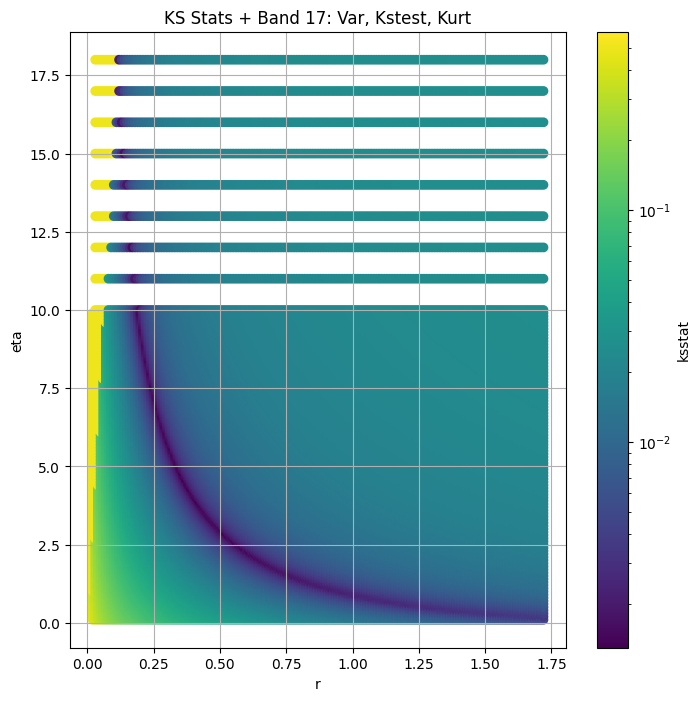

####
Band  20


100%|██████████| 55966/55966 [03:16<00:00, 284.18it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 381600.0


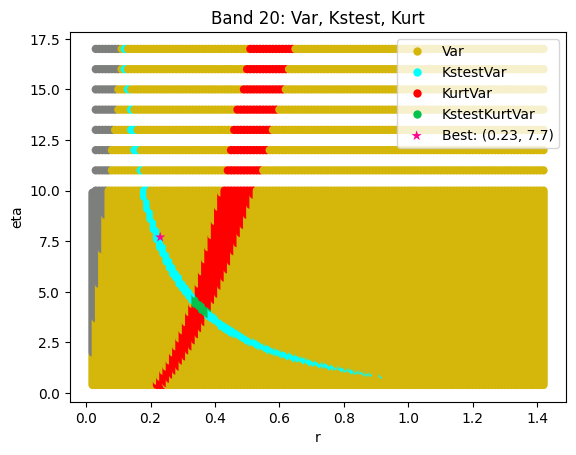

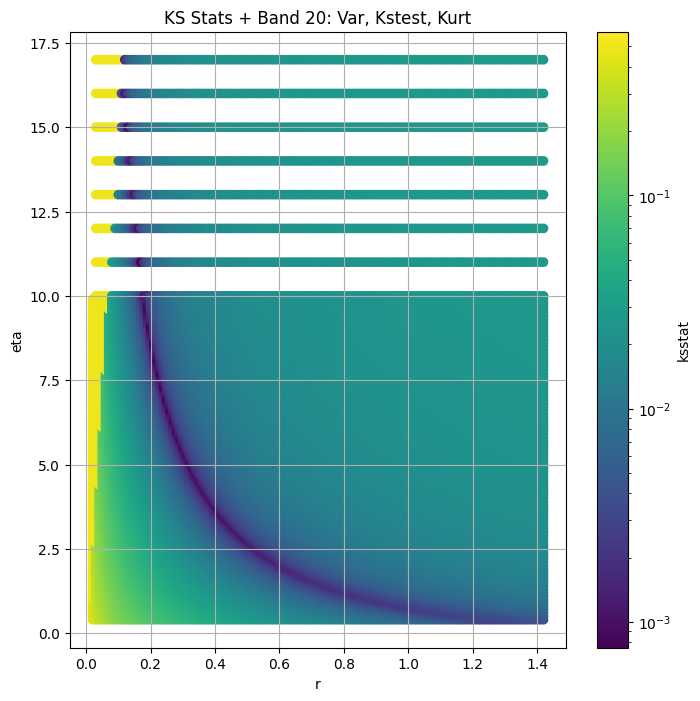

####
Band  23


100%|██████████| 55966/55966 [03:19<00:00, 280.87it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 610560.0


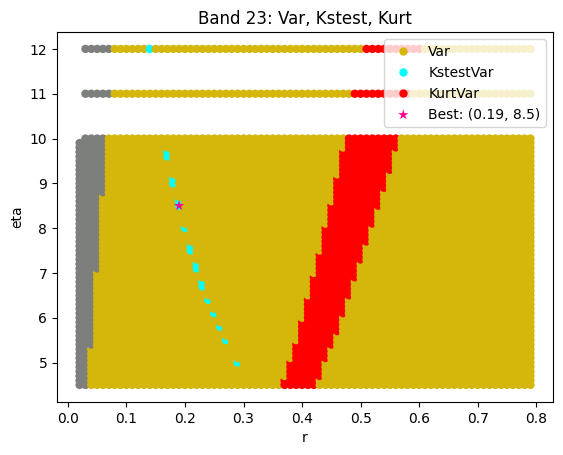

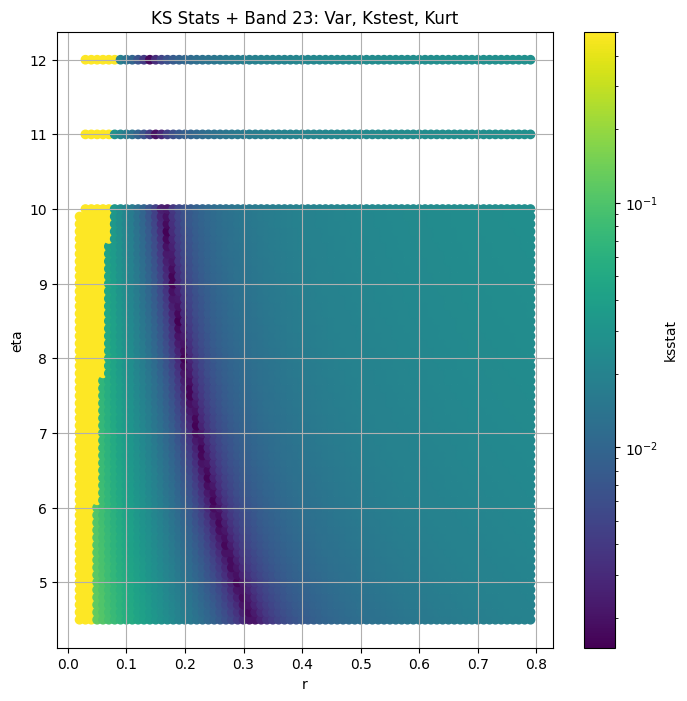

####
Band  26


100%|██████████| 55966/55966 [03:12<00:00, 290.12it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 973080.0


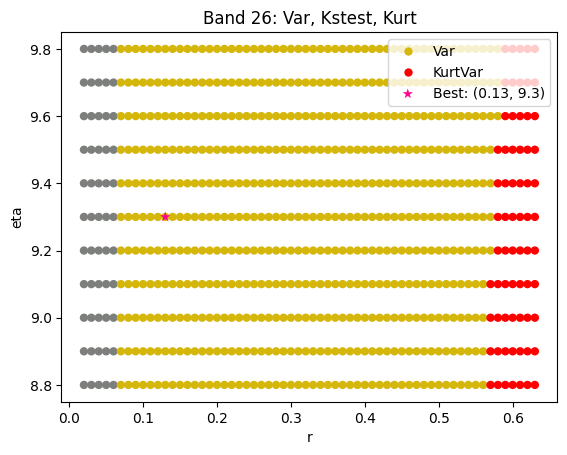

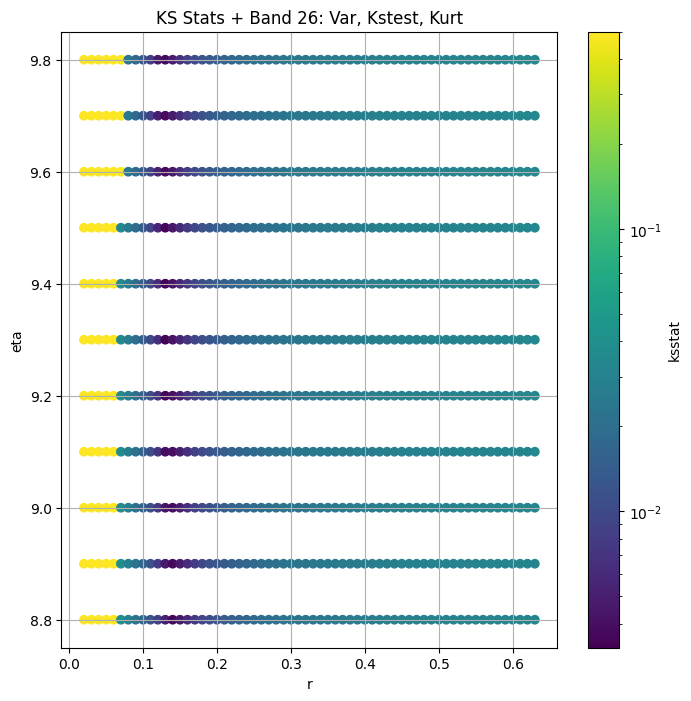

####
Band  29


100%|██████████| 55966/55966 [03:12<00:00, 290.40it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 1376940.0


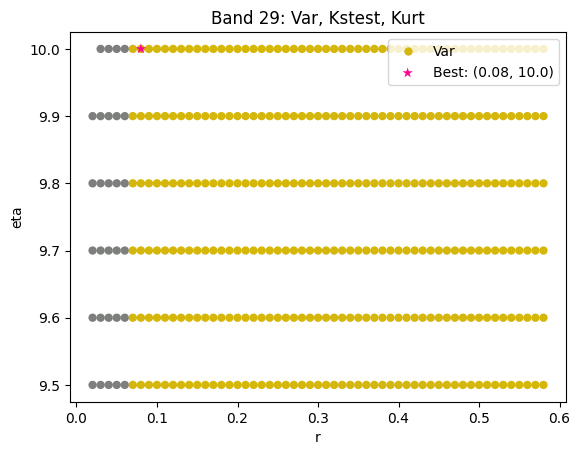

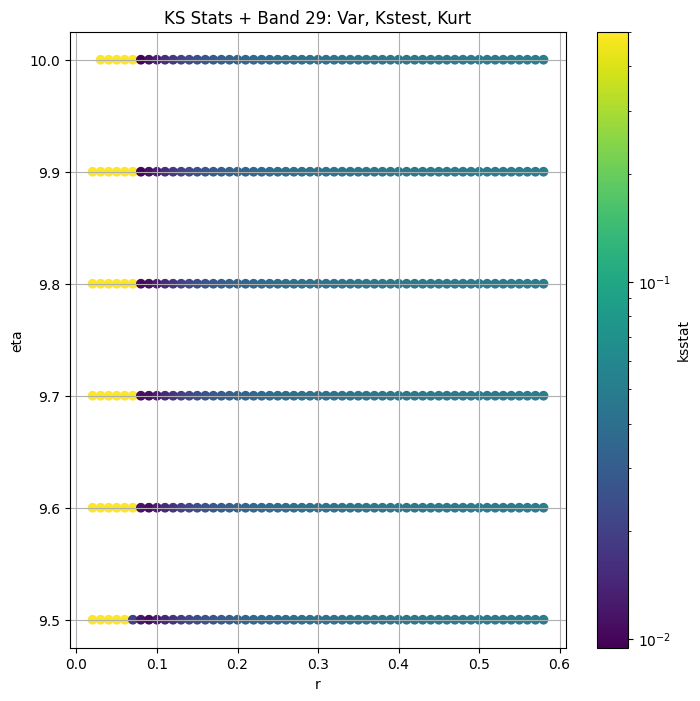

####
Band  32


100%|██████████| 55966/55966 [03:11<00:00, 292.95it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 419760.0


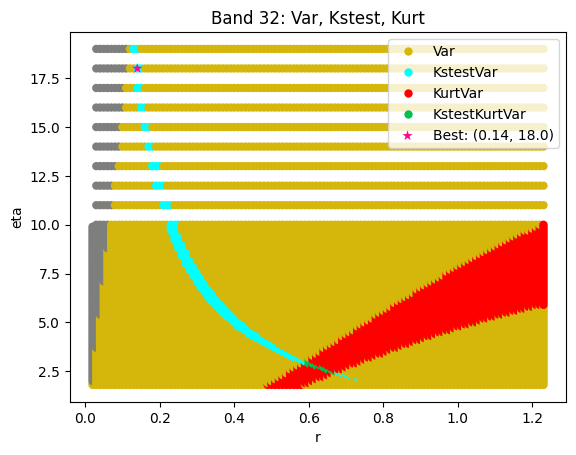

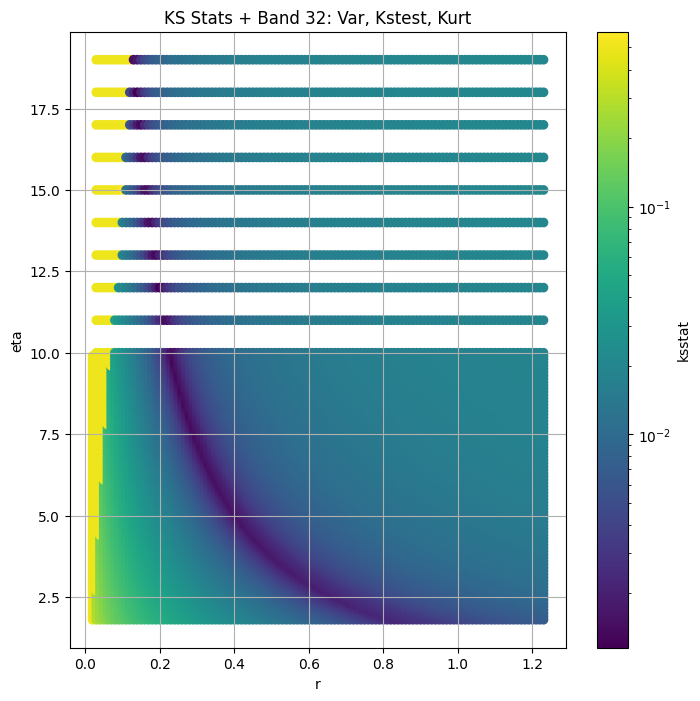

obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
band                                                                       
2     238621.340000  227525.050000  250164.660000   1.329861    0.962390   
5     125861.800000  119992.660000  131988.280000   1.392025    0.909872   
8      66732.330000   63640.670000   69916.100000   1.377129    0.967720   
11     36748.125000   34953.164000   38624.617000   1.727334    1.042835   
14     19290.611000   18380.465000   20250.715000   1.563712    0.985900   
17     10338.449000    9839.270500   10859.774000   1.652823    1.062084   
20      4938.306600    4692.662600    5208.717000   2.060602    1.170981   
23      2210.008000    2095.980200    2333.351800   2.336577    1.422220   
26       871.890900     814.146850     942.188800   5.787819    2.479208   
29       297.936550     265.633850     344.980260  23.688461    6.687737   
32        25.905695      24.708324      27.137707   1.305109    0.893868   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  \
band                                                                     
2       1.772640        31800.0       0.26          8.0   2.013616e-01   
5       2.123118        41340.0       0.13         19.0   1.329917e-12   
8       1.917665        66780.0       1.04          1.2   2.684428e+04   
11      3.028584       104940.0       0.17         13.0   1.365409e-07   
14      3.021425       162180.0       0.35          5.8   2.902545e+00   
17      3.063314       257580.0       0.42          3.9   2.092382e+01   
20      6.707925       381600.0       0.23          7.7   4.482306e-04   
23      4.876342       610560.0       0.19          8.5   1.567844e-06   
26     17.814651       973080.0       0.13          9.3   1.107631e-12   
29     80.945920      1376940.0       0.08         10.0   1.961918e-25   
32      2.017627       419760.0       0.14         18.0   1.077541e-14   

      kstest_stat_initial  kstest_stat_cutoff_0.05  
band                                                
2                0.003604                 0.007611  
5                0.002263                 0.006675  
8                0.003009                 0.005253  
11               0.001161                 0.004191  
14               0.003234                 0.003371  
17               0.001297                 0.002675  
20               0.000755                 0.002198  
23               0.001512                 0.001738  
26               0.003288                 0.001377  
29               0.009453                 0.001157  
32               0.001153                 0.002096

In [8]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        
        group_cdf_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / group_cdf_df['variance'], 0, 1e5)
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdf_df['scale'])
        initial_scale = group_cdf_df.loc[(group_cdf_df["r"] ==  initial_param[0]) & (group_cdf_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        master_df.loc[group, 'initial_scale'] = initial_scale
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df['variance'] = group_cdf_df['variance'] * group_cdf_df['scale']
        group_cdf_df['kurtosis'] = group_cdf_df['kurtosis'] * group_cdf_df['scale']

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = None,
                            best_param = initial_param)
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [9]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True, scales=group_cdf_df['scale'])
            best_scale_eta0 = group_cdf_df.loc[(group_cdf_df["r"] ==  best_param_eta0[0]) & (group_cdf_df["eta"] ==  best_param_eta0[1])]["scale"].iloc[0]
            master_df.loc[group, 'best_r_eta0'] = best_param_eta0[0]
            master_df.loc[group, 'best_scale_eta0'] = best_scale_eta0
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r_eta0'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_scale_eta0'] = master_df.loc[group, 'initial_scale']
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

100%|██████████| 369/369 [00:00<00:00, 775.88it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 676.10it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 413.94it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 288.94it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 289.34it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 290.18it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 287.73it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 281.95it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 286.08it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 285.42it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 284.82it/s]

Finding Minimum after computing 369 CDFs


obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
band                                                                       
2     238621.340000  227525.050000  250164.660000   1.329861    0.962390   
5     125861.800000  119992.660000  131988.280000   1.392025    0.909872   
8      66732.330000   63640.670000   69916.100000   1.377129    0.967720   
11     36748.125000   34953.164000   38624.617000   1.727334    1.042835   
14     19290.611000   18380.465000   20250.715000   1.563712    0.985900   
17     10338.449000    9839.270500   10859.774000   1.652823    1.062084   
20      4938.306600    4692.662600    5208.717000   2.060602    1.170981   
23      2210.008000    2095.980200    2333.351800   2.336577    1.422220   
26       871.890900     814.146850     942.188800   5.787819    2.479208   
29       297.936550     265.633850     344.980260  23.688461    6.687737   
32        25.905695      24.708324      27.137707   1.305109    0.893868   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  \
band                                                                     
2       1.772640        31800.0       0.26          8.0   2.013616e-01   
5       2.123118        41340.0       0.13         19.0   1.329917e-12   
8       1.917665        66780.0       1.04          1.2   2.684428e+04   
11      3.028584       104940.0       0.17         13.0   1.365409e-07   
14      3.021425       162180.0       0.35          5.8   2.902545e+00   
17      3.063314       257580.0       0.42          3.9   2.092382e+01   
20      6.707925       381600.0       0.23          7.7   4.482306e-04   
23      4.876342       610560.0       0.19          8.5   1.567844e-06   
26     17.814651       973080.0       0.13          9.3   1.107631e-12   
29     80.945920      1376940.0       0.08         10.0   1.961918e-25   
32      2.017627       419760.0       0.14         18.0   1.077541e-14   

      kstest_stat_initial  kstest_stat_cutoff_0.05  best_r_eta0  \
band                                                              
2                0.003604                 0.007611         0.73   
5                0.002263                 0.006675         1.03   
8                0.003009                 0.005253         2.40   
11               0.001161                 0.004191         6.00   
14               0.003234                 0.003371         6.00   
17               0.001297                 0.002675         6.00   
20               0.000755                 0.002198         6.00   
23               0.001512                 0.001738         6.00   
26               0.003288                 0.001377         5.90   
29               0.009453                 0.001157         5.80   
32               0.001153                 0.002096         5.80   

      best_scale_eta0  kstest_stat_eta0  
band                                     
2            8.669246          0.015226  
5           18.141329          0.011376  
8           38.013573          0.005916  
11          44.146381          0.058689  
14          44.146381          0.125835  
17          44.146381          0.187337  
20          44.146381          0.251639  
23          44.146381          0.310924  
26          44.117061          0.365887  
29          44.085423          0.413555  
32          44.085423          0.466481

## Optimization

In [10]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Band 2
(0.252, 7.99), 50 of 420
(0.254, 8.09), 100 of 420
(0.257, 7.99), 150 of 420
(0.259, 8.09), 200 of 420
(0.262, 7.99), 250 of 420
(0.264, 8.09), 300 of 420
(0.267, 7.99), 350 of 420
(0.269, 8.09), 400 of 420


100%|██████████| 420/420 [00:00<00:00, 877.63it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 2 best parameters: ((0.261, 7.96), 0.003600952831450288)


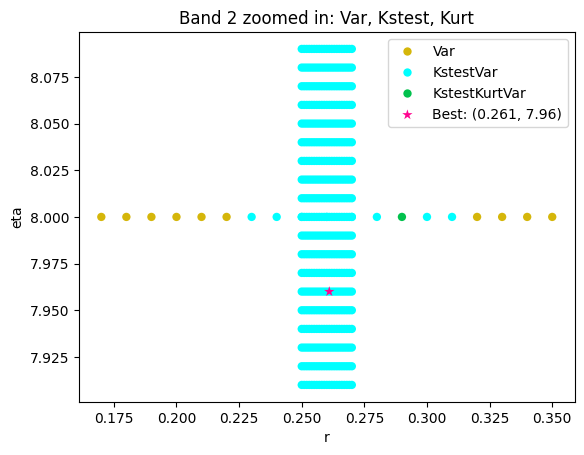

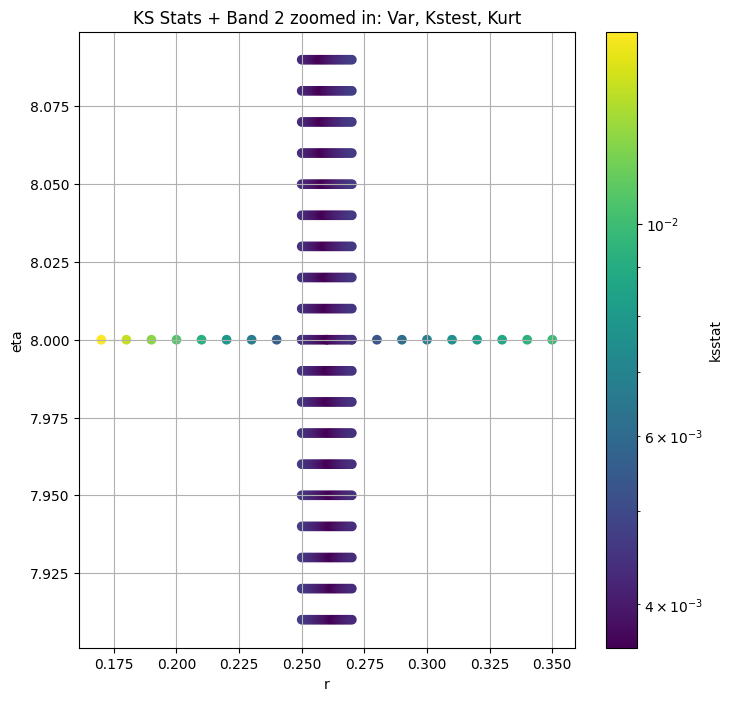

Band 5


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:76: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * special.gamma(beta + 1/r) / special.gamma(beta)


(0.122, 18.9), 50 of 420
(0.124, 19.9), 100 of 420
(0.127, 18.9), 150 of 420
(0.129, 19.9), 200 of 420
(0.132, 18.9), 250 of 420
(0.134, 19.9), 300 of 420
(0.137, 18.9), 350 of 420
(0.139, 19.9), 400 of 420


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamm

Finding Minimum after computing 420 CDFs
Iter 1 band 5 best parameters: ((0.128, 19.4), 0.002212092538303345)


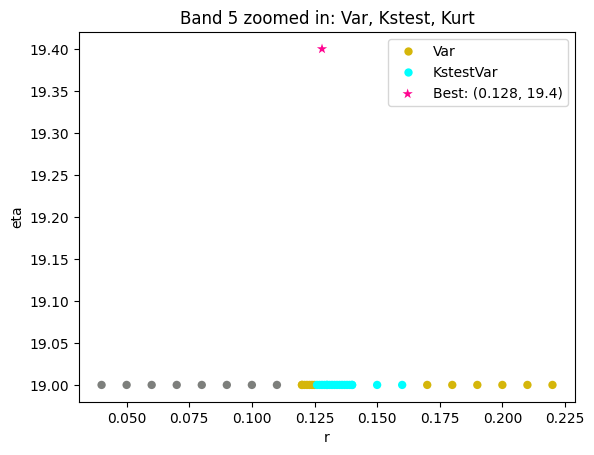

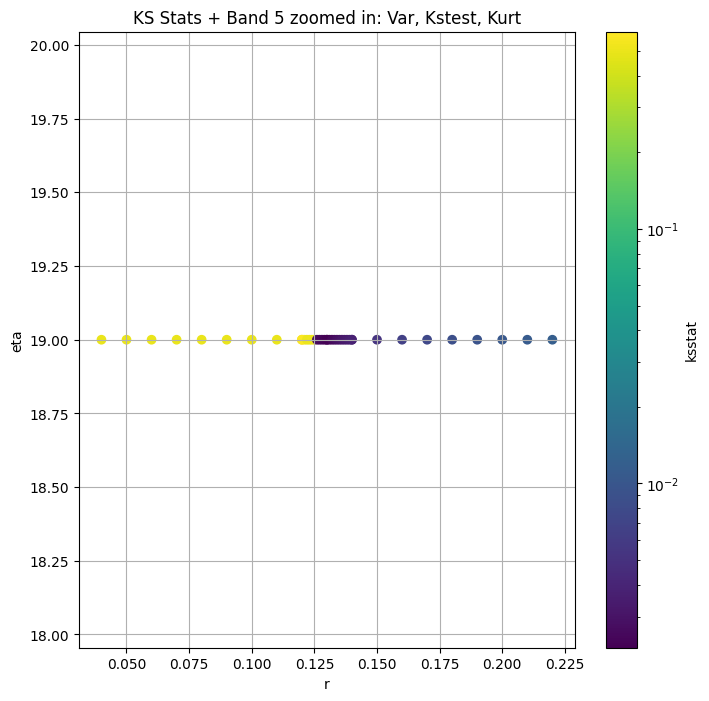

Band 8
(1.032, 1.17), 50 of 441
(1.034, 1.25), 100 of 441
(1.037, 1.12), 150 of 441
(1.039, 1.2), 200 of 441
(1.041, 1.28), 250 of 441
(1.044, 1.15), 300 of 441
(1.046, 1.23), 350 of 441
(1.049, 1.1), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 417.34it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 8 best parameters: ((1.049, 1.18), 0.0030063380145001206)


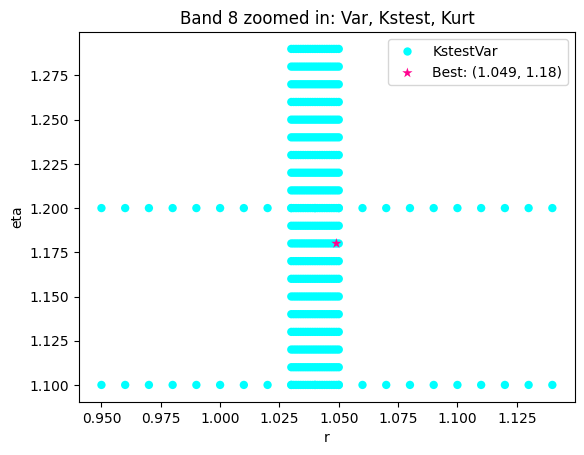

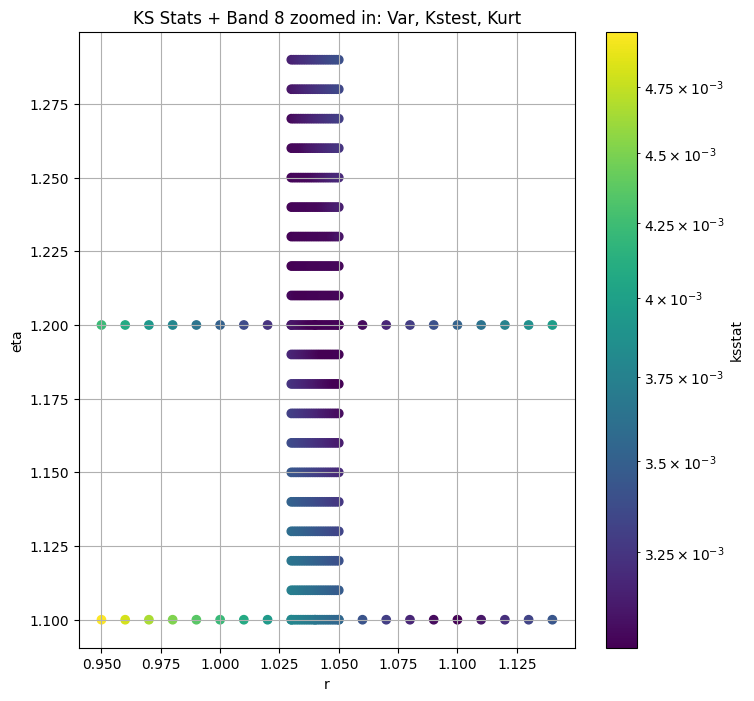

Band 11
(0.162, 12.9), 50 of 420
(0.164, 13.9), 100 of 420
(0.167, 12.9), 150 of 420
(0.169, 13.9), 200 of 420
(0.172, 12.9), 250 of 420
(0.174, 13.9), 300 of 420
(0.177, 12.9), 350 of 420
(0.179, 13.9), 400 of 420


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
100%|██████████| 420/420 [00:01<00:00, 297.30it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 11 best parameters: ((0.176, 12.5), 0.0011571279021415082)


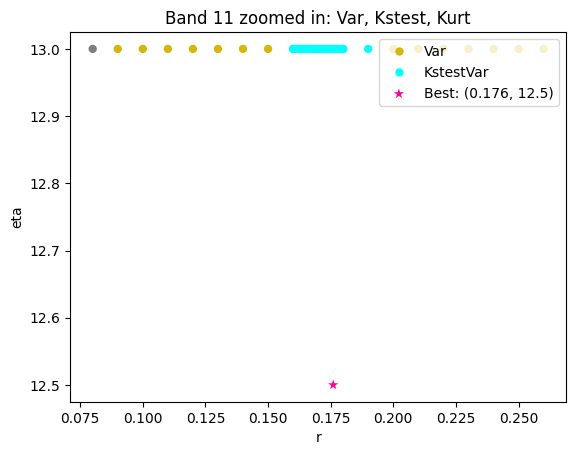

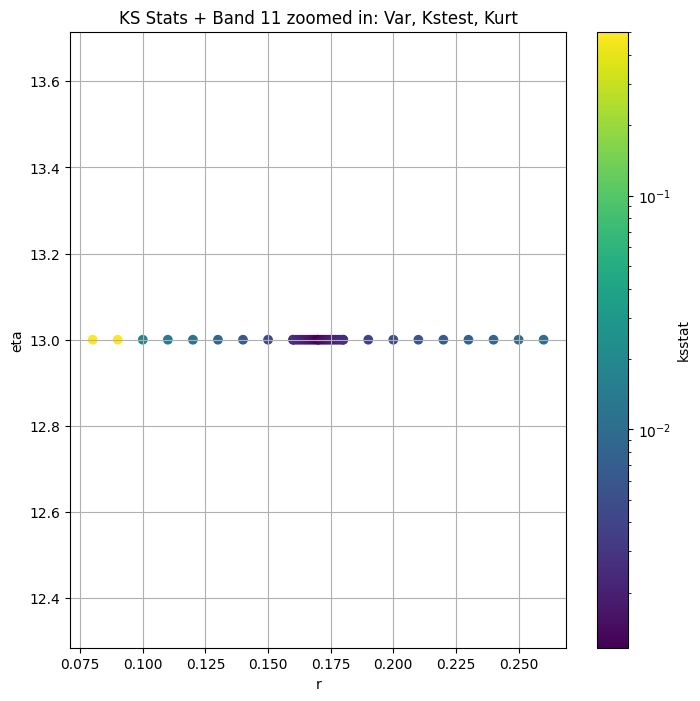

Band 14
(0.342, 5.79), 50 of 420
(0.344, 5.89), 100 of 420
(0.347, 5.79), 150 of 420
(0.349, 5.89), 200 of 420
(0.352, 5.79), 250 of 420
(0.354, 5.89), 300 of 420
(0.357, 5.79), 350 of 420
(0.359, 5.89), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 292.19it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 14 best parameters: ((0.351, 5.78), 0.0032339560173582083)


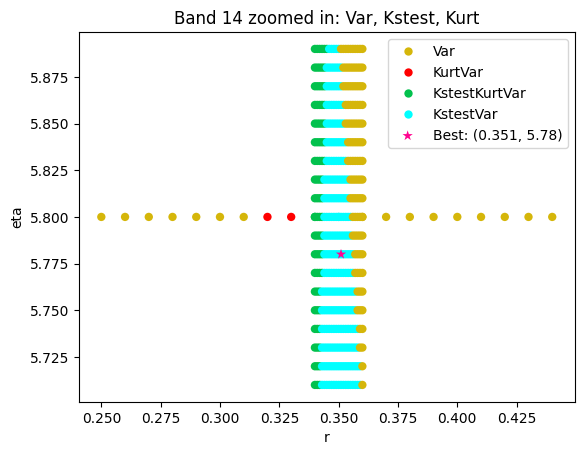

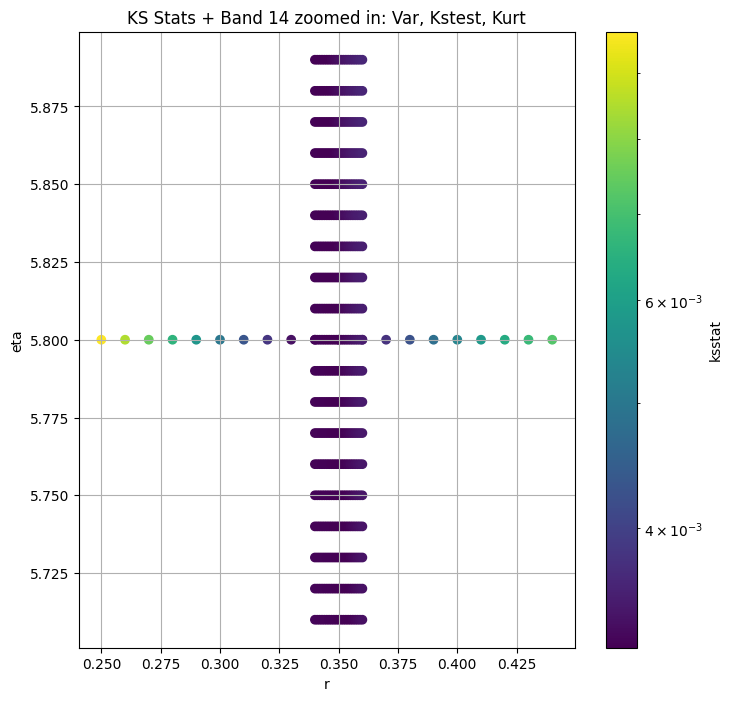

Band 17
(0.412, 3.87), 50 of 441
(0.414, 3.95), 100 of 441
(0.417, 3.82), 150 of 441
(0.419, 3.9), 200 of 441
(0.421, 3.98), 250 of 441
(0.424, 3.85), 300 of 441
(0.426, 3.93), 350 of 441
(0.429, 3.8), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 296.33it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 17 best parameters: ((0.417, 3.94), 0.0012898135283265777)


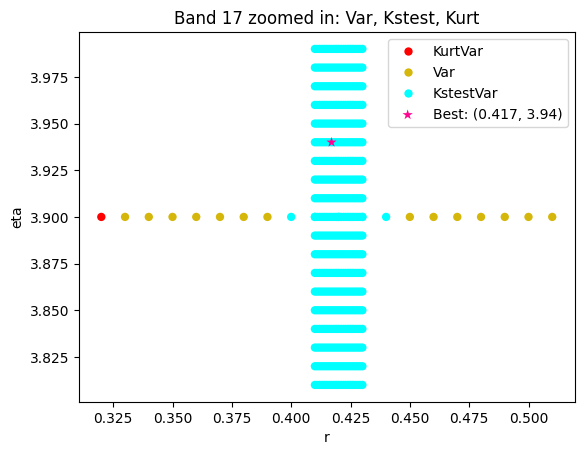

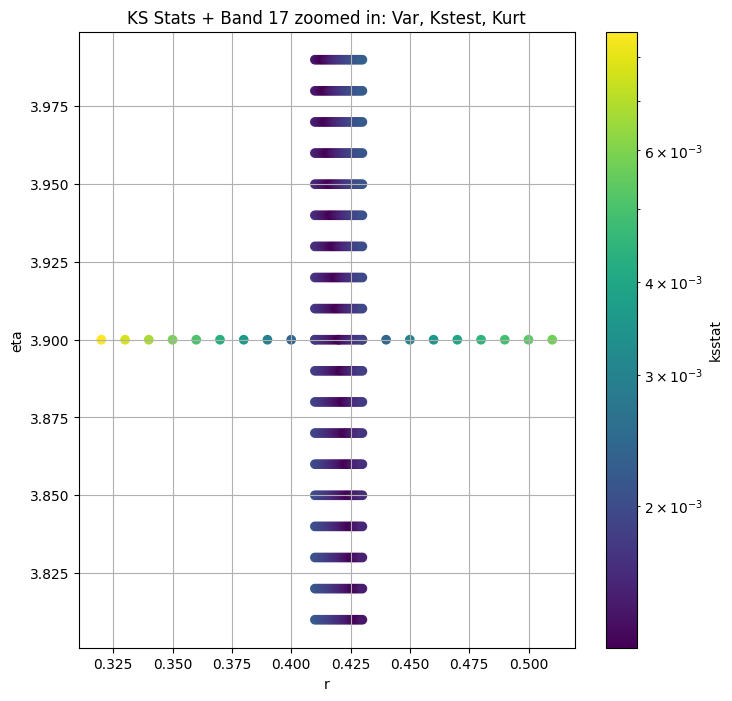

Band 20
(0.222, 7.69), 50 of 420
(0.224, 7.79), 100 of 420
(0.227, 7.69), 150 of 420
(0.229, 7.79), 200 of 420
(0.232, 7.69), 250 of 420
(0.234, 7.79), 300 of 420
(0.237, 7.69), 350 of 420
(0.239, 7.79), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 298.06it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 20 best parameters: ((0.228, 7.78), 0.0007494995316499331)


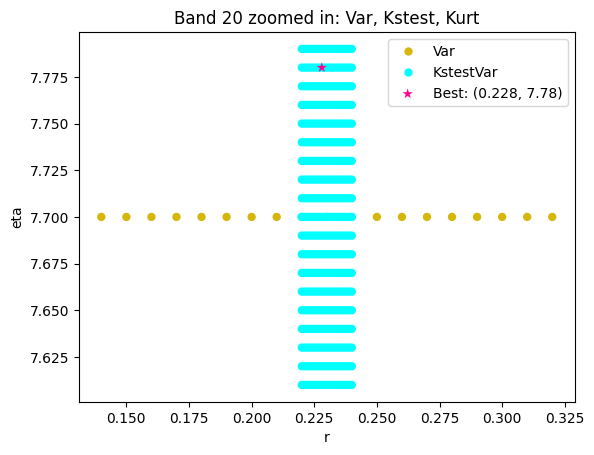

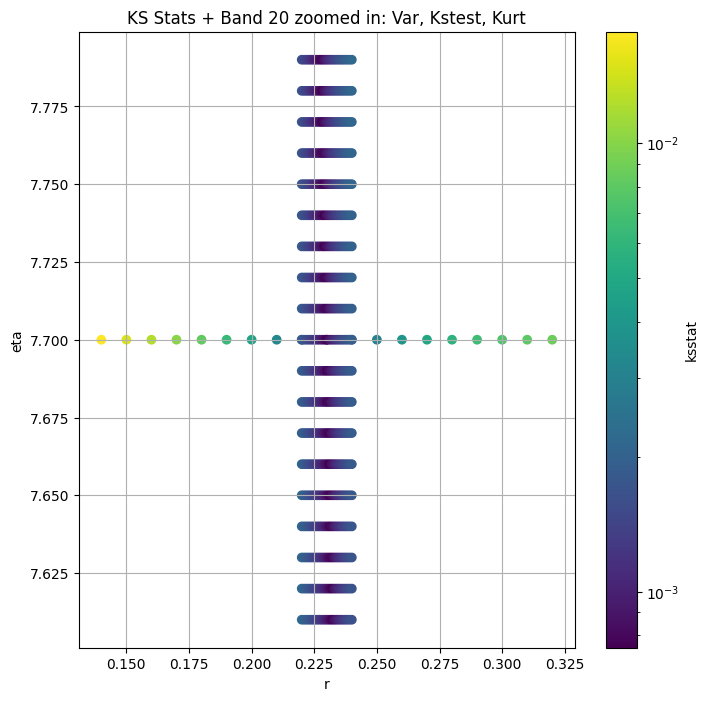

Band 23
(0.182, 8.49), 50 of 420
(0.184, 8.59), 100 of 420
(0.187, 8.49), 150 of 420
(0.189, 8.59), 200 of 420
(0.192, 8.49), 250 of 420
(0.194, 8.59), 300 of 420
(0.197, 8.49), 350 of 420
(0.199, 8.59), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 298.53it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 23 best parameters: ((0.191, 8.44), 0.0015042477371726148)


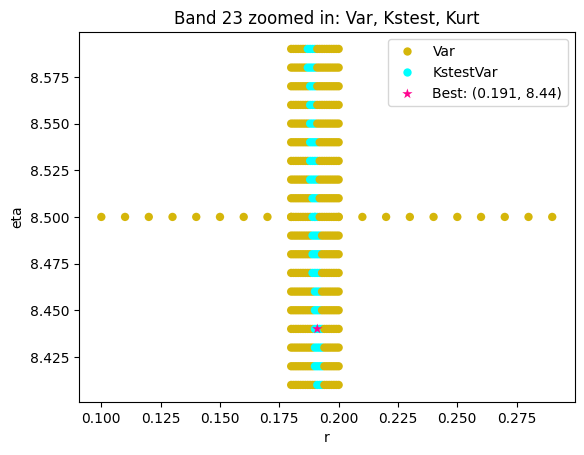

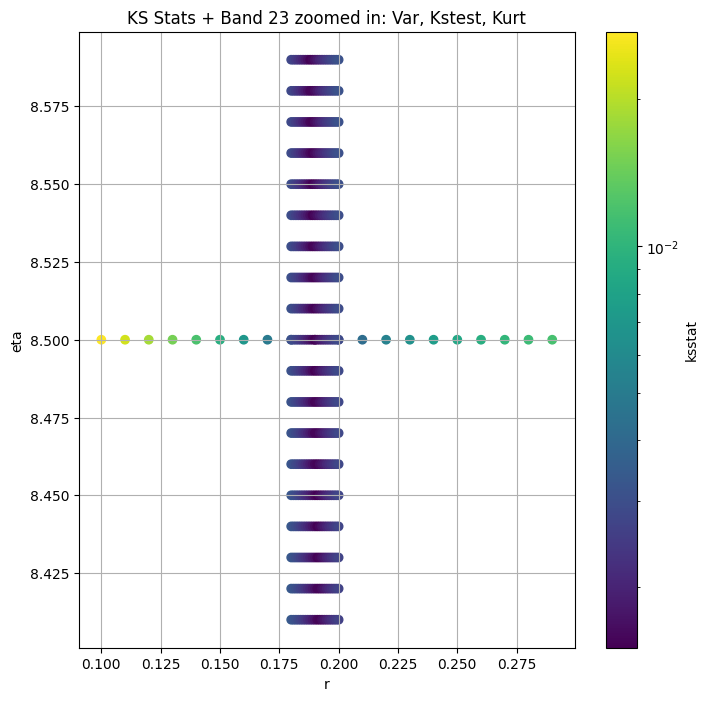

Band 26
(0.122, 9.29), 50 of 420
(0.124, 9.39), 100 of 420
(0.127, 9.29), 150 of 420
(0.129, 9.39), 200 of 420
(0.132, 9.29), 250 of 420
(0.134, 9.39), 300 of 420
(0.137, 9.29), 350 of 420
(0.139, 9.39), 400 of 420


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
100%|██████████| 420/420 [00:01<00:00, 295.01it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 26 best parameters: ((0.129, 9.36), 0.0032584522698336227)


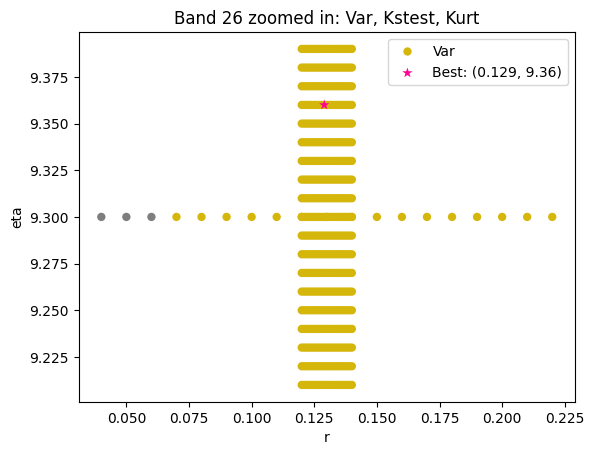

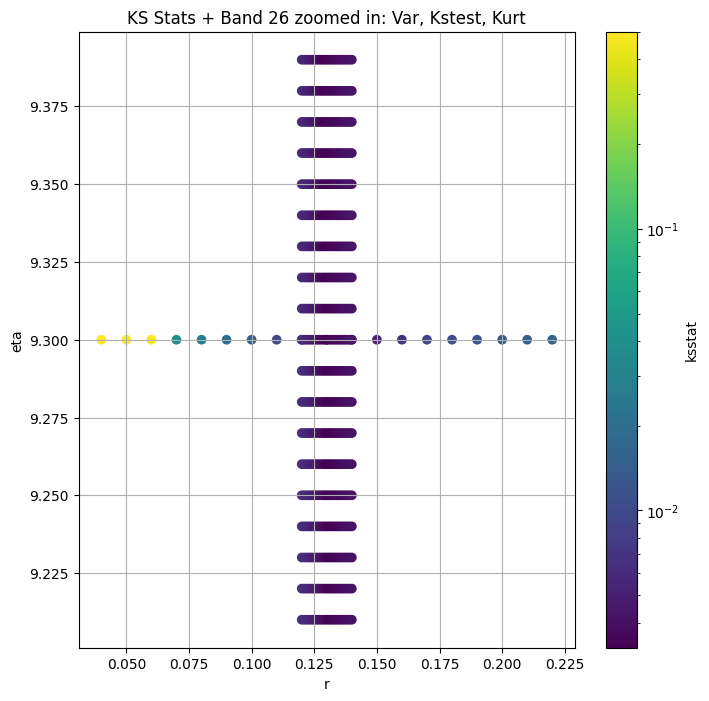

Band 29


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:76: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * special.gamma(beta + 1/r) / special.gamma(beta)


(0.072, 9.9), 50 of 400
(0.074, 10.9), 100 of 400
(0.077, 9.9), 150 of 400
(0.079, 10.9), 200 of 400
(0.082, 9.9), 250 of 400
(0.084, 10.9), 300 of 400
(0.087, 9.9), 350 of 400
(0.089, 10.9), 400 of 400


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamm

Finding Minimum after computing 400 CDFs
Iter 1 band 29 best parameters: ((0.079, 10.1), 0.009424866577601887)


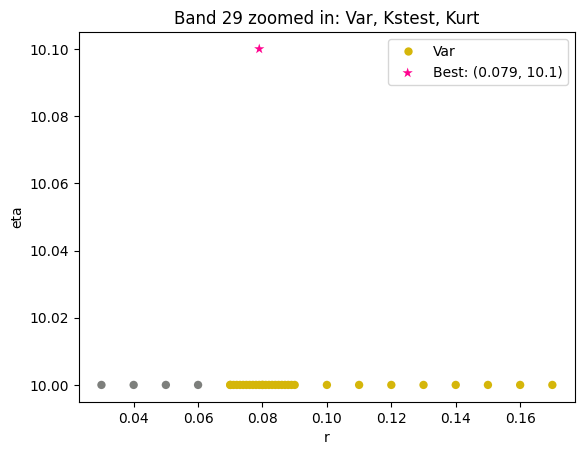

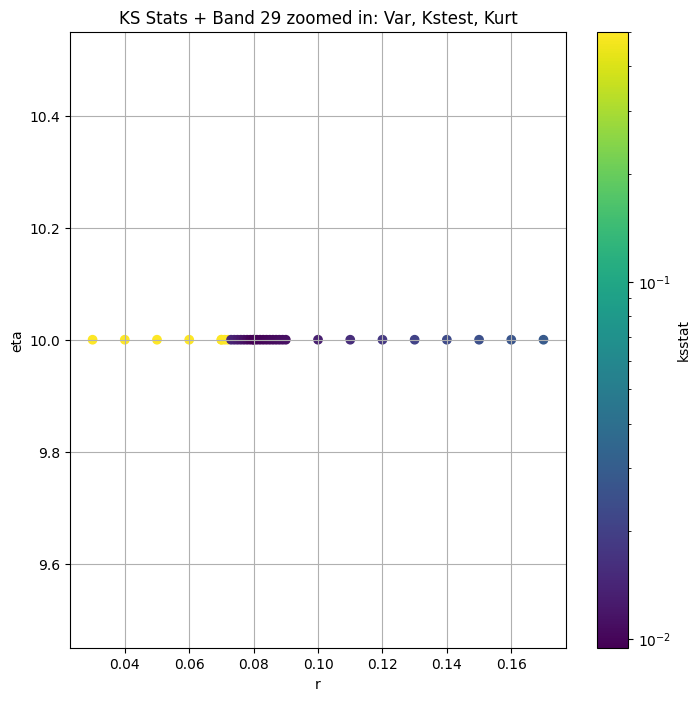

Band 32
(0.132, 17.9), 50 of 420
(0.134, 18.9), 100 of 420
(0.137, 17.9), 150 of 420
(0.139, 18.9), 200 of 420
(0.142, 17.9), 250 of 420
(0.144, 18.9), 300 of 420
(0.147, 17.9), 350 of 420
(0.149, 18.9), 400 of 420


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
100%|██████████| 420/420 [00:01<00:00, 299.27it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 32 best parameters: ((0.134, 18.8), 0.0011039545942078677)


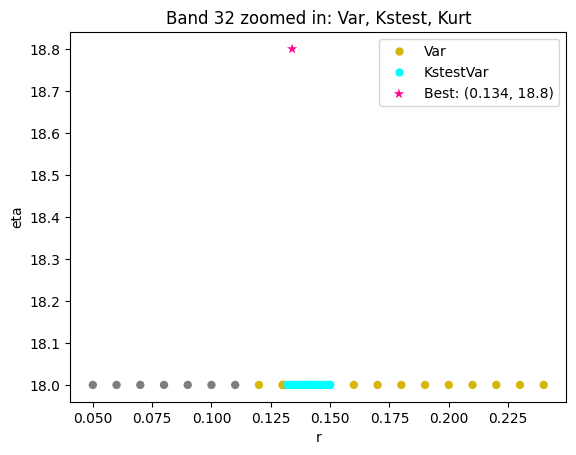

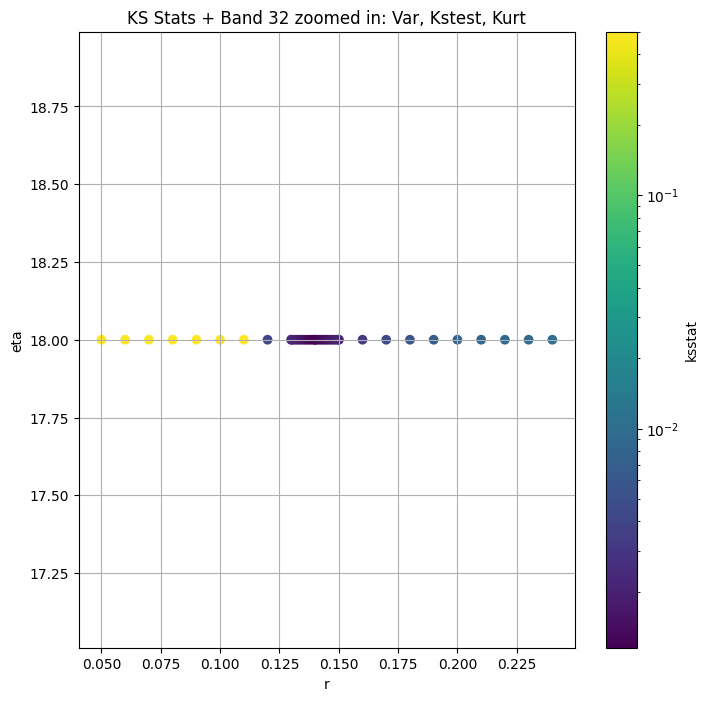

obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
band                                                                       
2     238621.340000  227525.050000  250164.660000   1.329861    0.962390   
5     125861.800000  119992.660000  131988.280000   1.392025    0.909872   
8      66732.330000   63640.670000   69916.100000   1.377129    0.967720   
11     36748.125000   34953.164000   38624.617000   1.727334    1.042835   
14     19290.611000   18380.465000   20250.715000   1.563712    0.985900   
17     10338.449000    9839.270500   10859.774000   1.652823    1.062084   
20      4938.306600    4692.662600    5208.717000   2.060602    1.170981   
23      2210.008000    2095.980200    2333.351800   2.336577    1.422220   
26       871.890900     814.146850     942.188800   5.787819    2.479208   
29       297.936550     265.633850     344.980260  23.688461    6.687737   
32        25.905695      24.708324      27.137707   1.305109    0.893868   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
band                                                                    ...   
2       1.772640        31800.0       0.26          8.0   2.013616e-01  ...   
5       2.123118        41340.0       0.13         19.0   1.329917e-12  ...   
8       1.917665        66780.0       1.04          1.2   2.684428e+04  ...   
11      3.028584       104940.0       0.17         13.0   1.365409e-07  ...   
14      3.021425       162180.0       0.35          5.8   2.902545e+00  ...   
17      3.063314       257580.0       0.42          3.9   2.092382e+01  ...   
20      6.707925       381600.0       0.23          7.7   4.482306e-04  ...   
23      4.876342       610560.0       0.19          8.5   1.567844e-06  ...   
26     17.814651       973080.0       0.13          9.3   1.107631e-12  ...   
29     80.945920      1376940.0       0.08         10.0   1.961918e-25  ...   
32      2.017627       419760.0       0.14         18.0   1.077541e-14  ...   

      best_scale_eta0  kstest_stat_eta0  best_r  best_eta    best_scale  \
band                                                                      
2            8.669246          0.015226   0.261      7.96  2.190192e-01   
5           18.141329          0.011376   0.128     19.40  5.515463e-13   
8           38.013573          0.005916   1.049      1.18  2.751475e+04   
11          44.146381          0.058689   0.176     12.50  4.956723e-07   
14          44.146381          0.125835   0.351      5.78  3.023669e+00   
17          44.146381          0.187337   0.417      3.94  1.932922e+01   
20          44.146381          0.251639   0.228      7.78  3.606209e-04   
23          44.146381          0.310924   0.191      8.44  1.855278e-06   
26          44.117061          0.365887   0.129      9.36  7.670659e-13   
29          44.085423          0.413555   0.079     10.10  6.814493e-26   
32          44.085423          0.466481   0.134     18.80  1.185014e-15   

      kstest_stat_best  iter1_r  iter1_eta  kstest_stat_iter1  n_pval_0.05  
band                                                                        
2             0.003601    0.261       7.96           0.003601       135831  
5             0.002212    0.128      19.40           0.002212       397309  
8             0.003006    1.049       1.18           0.003006       213934  
11            0.001157    0.176      12.50           0.001157      1344745  
14            0.003234    0.351       5.78           0.003234       182452  
17            0.001290    0.417       3.94           0.001290      1100247  
20            0.000749    0.228       7.78           0.000749      3259996  
23            0.001504    0.191       8.44           0.001504       825184  
26            0.003258    0.129       9.36           0.003258       182452  
29            0.009425    0.079      10.10           0.009425        21514  
32            0.001104    0.134      18.80           0.001104      1593775  

[11 rows x 23 col

In [11]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / temp_df['variance'], 0, 1e5)
                temp_df['variance'] = temp_df['variance'] * temp_df['scale']
                temp_df['kurtosis'] = temp_df['kurtosis'] * temp_df['scale']
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True, scales=temp_df['scale'])
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                best_scale = temp_df.loc[(temp_df["r"] ==  best_param[0])&(temp_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'best_scale'] = best_scale
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

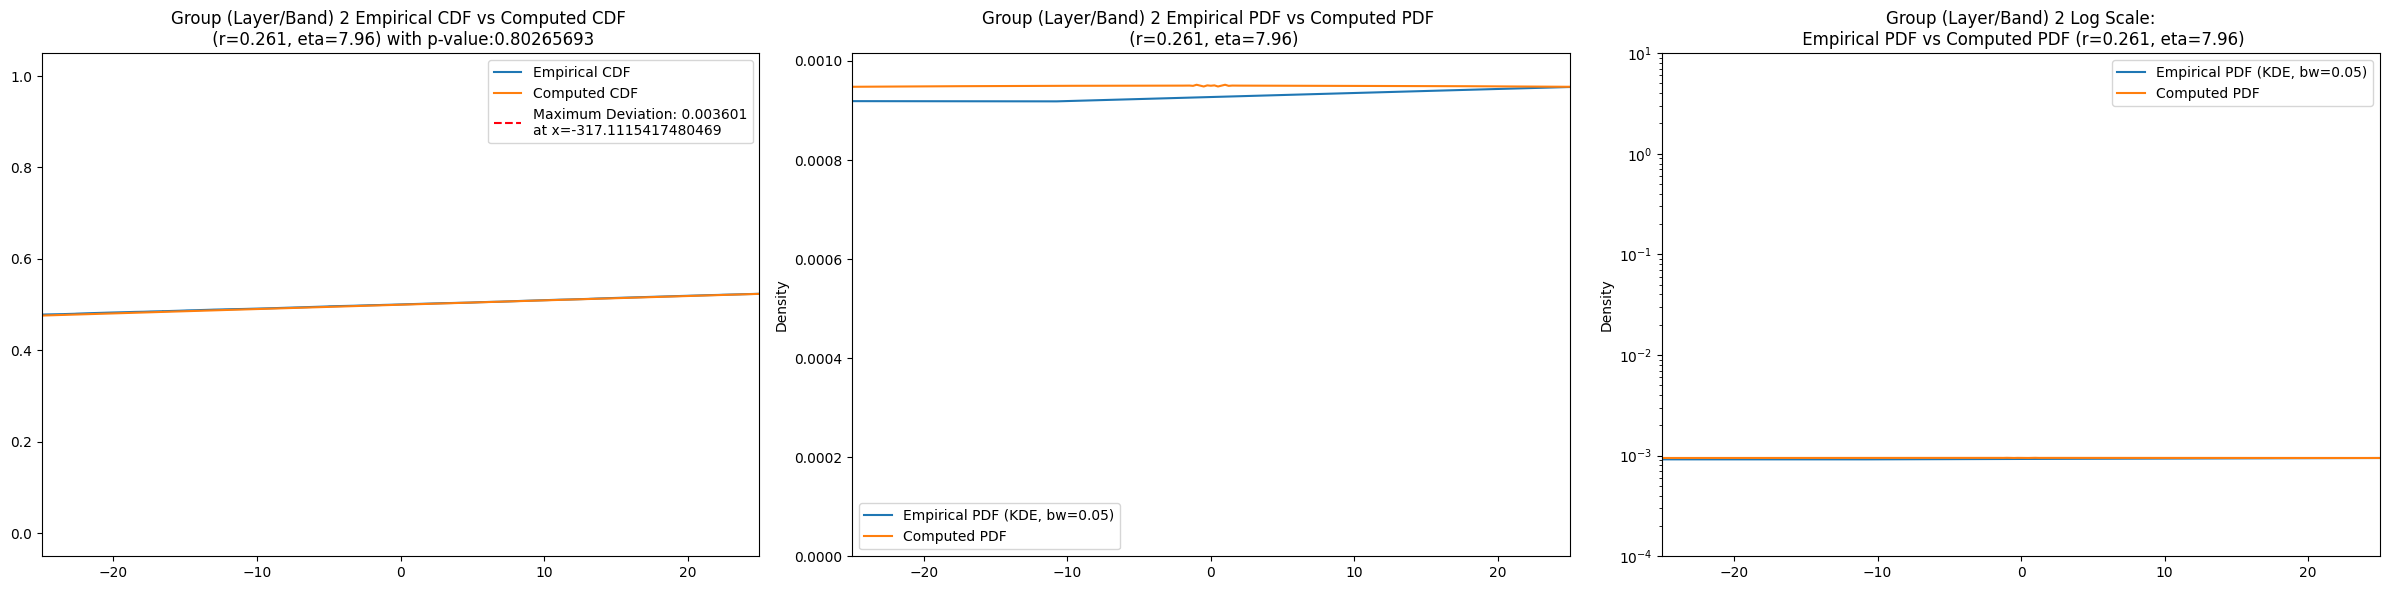

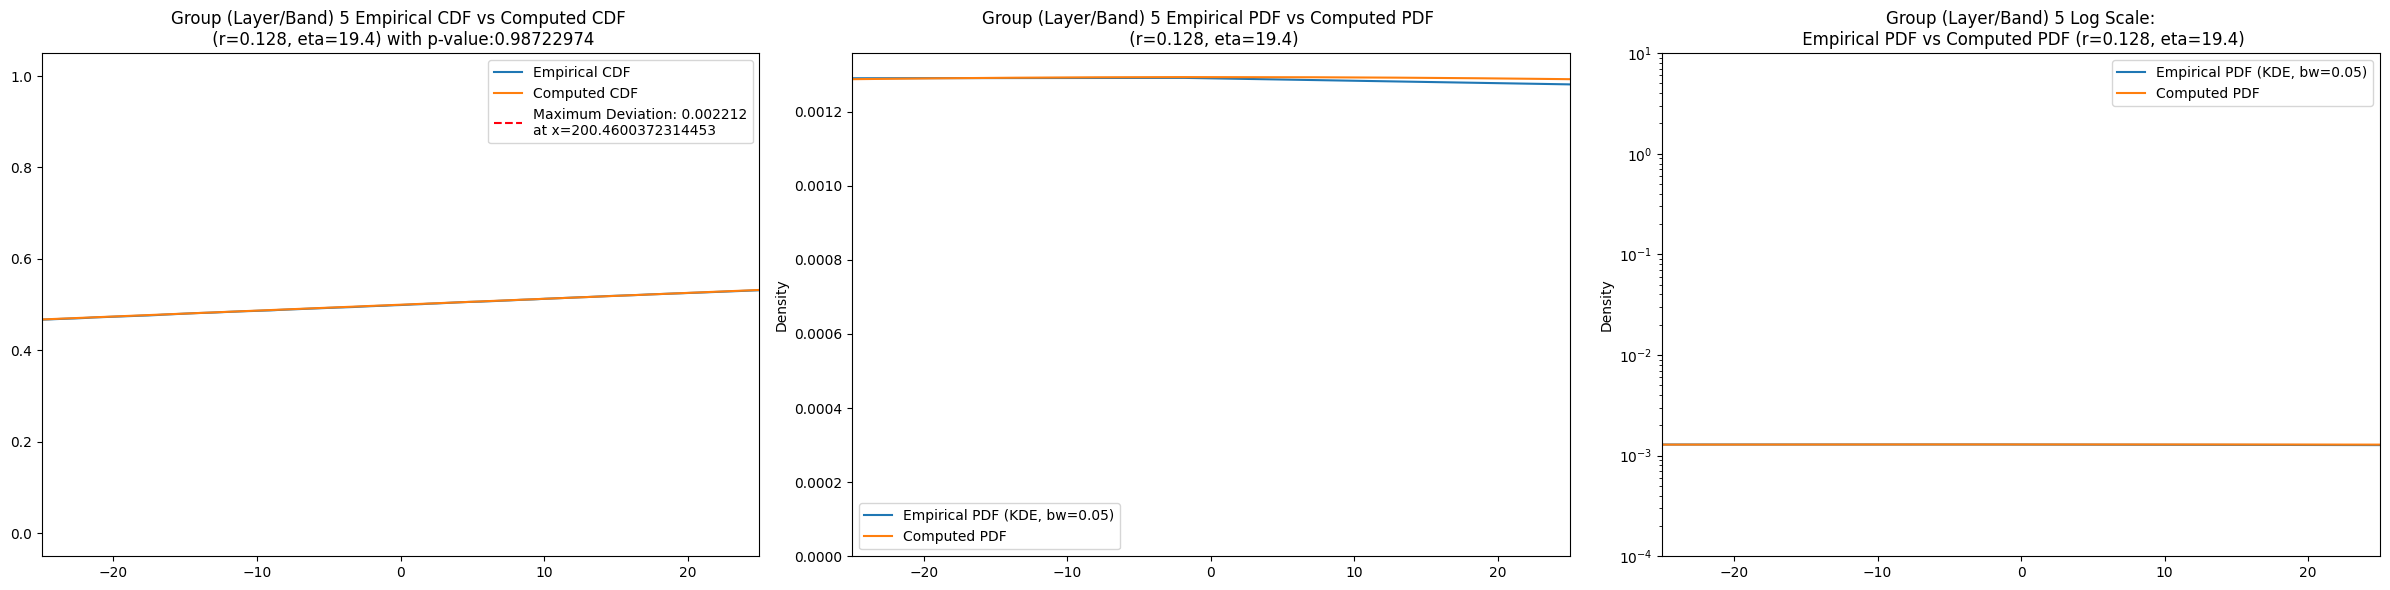

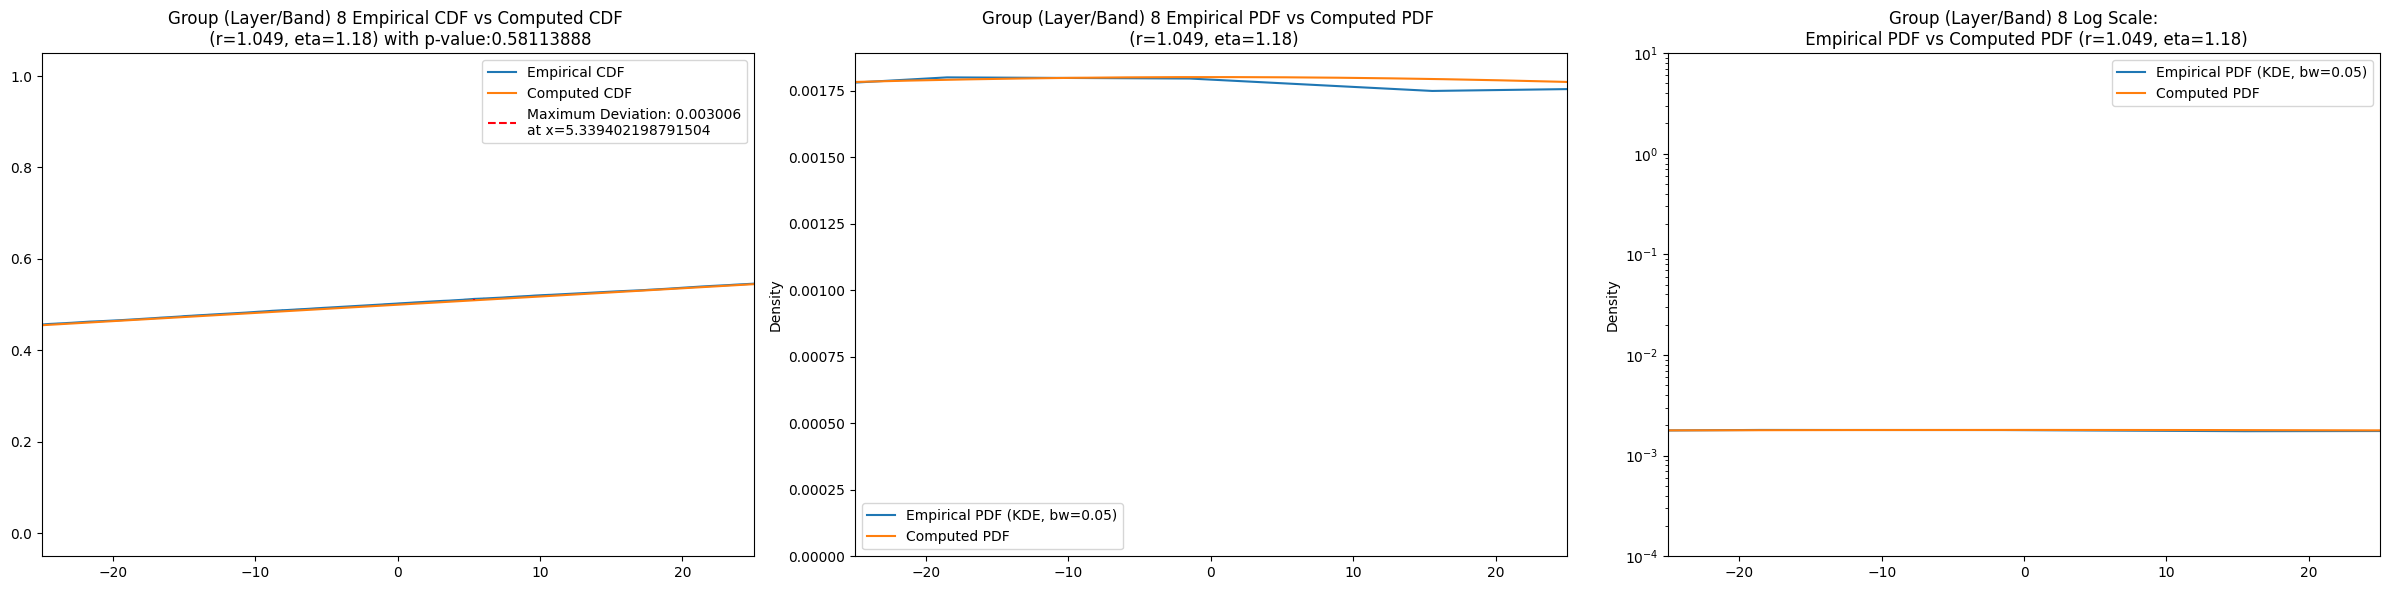

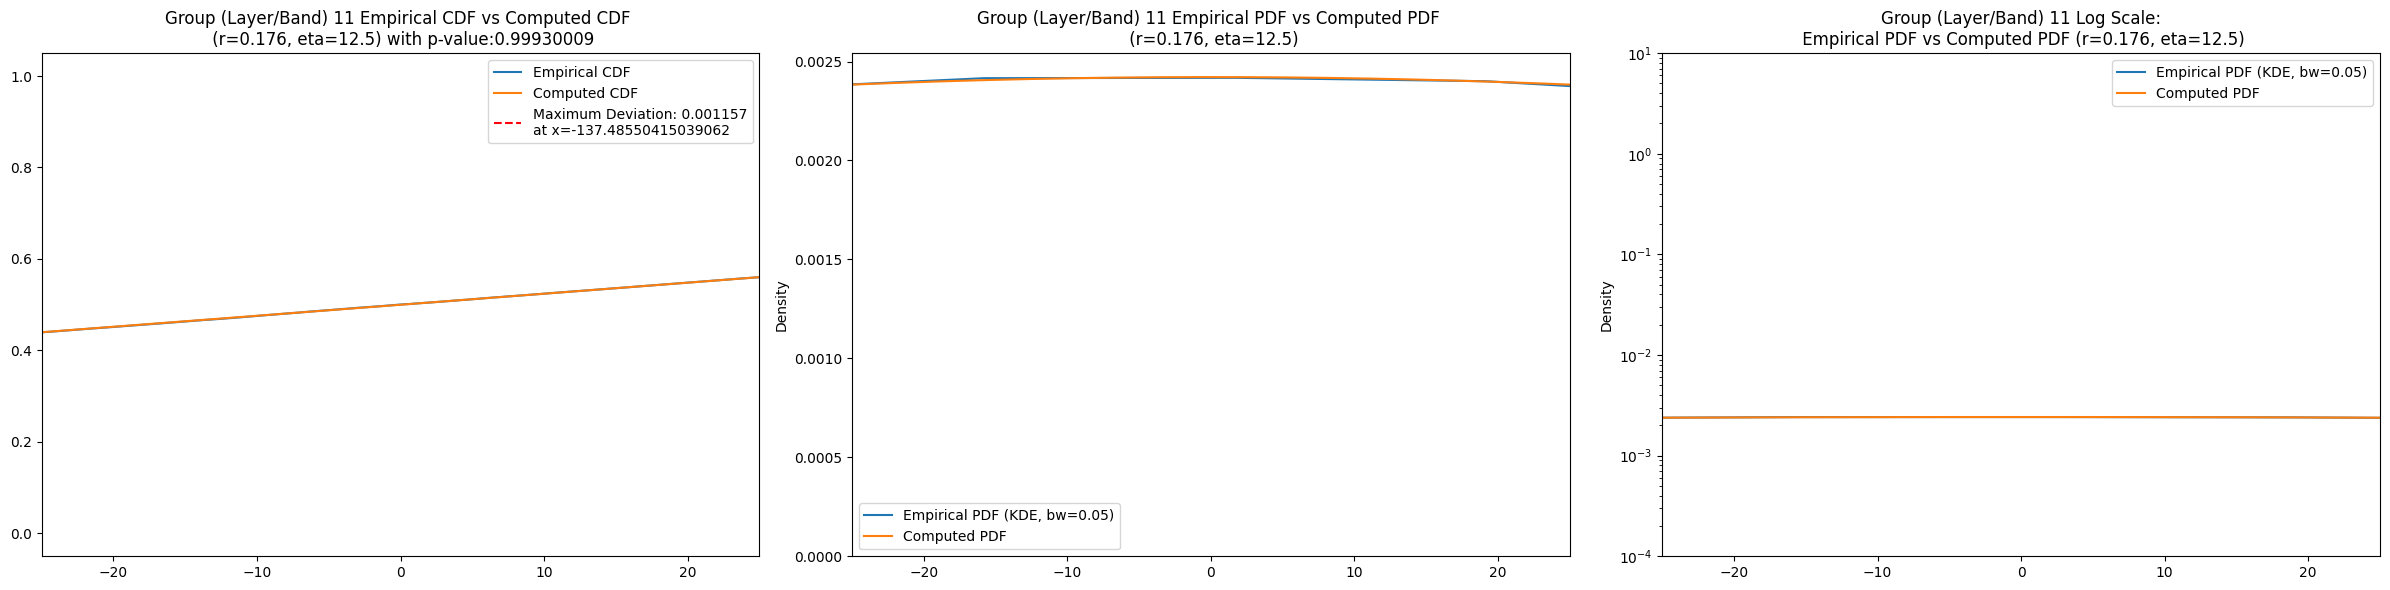

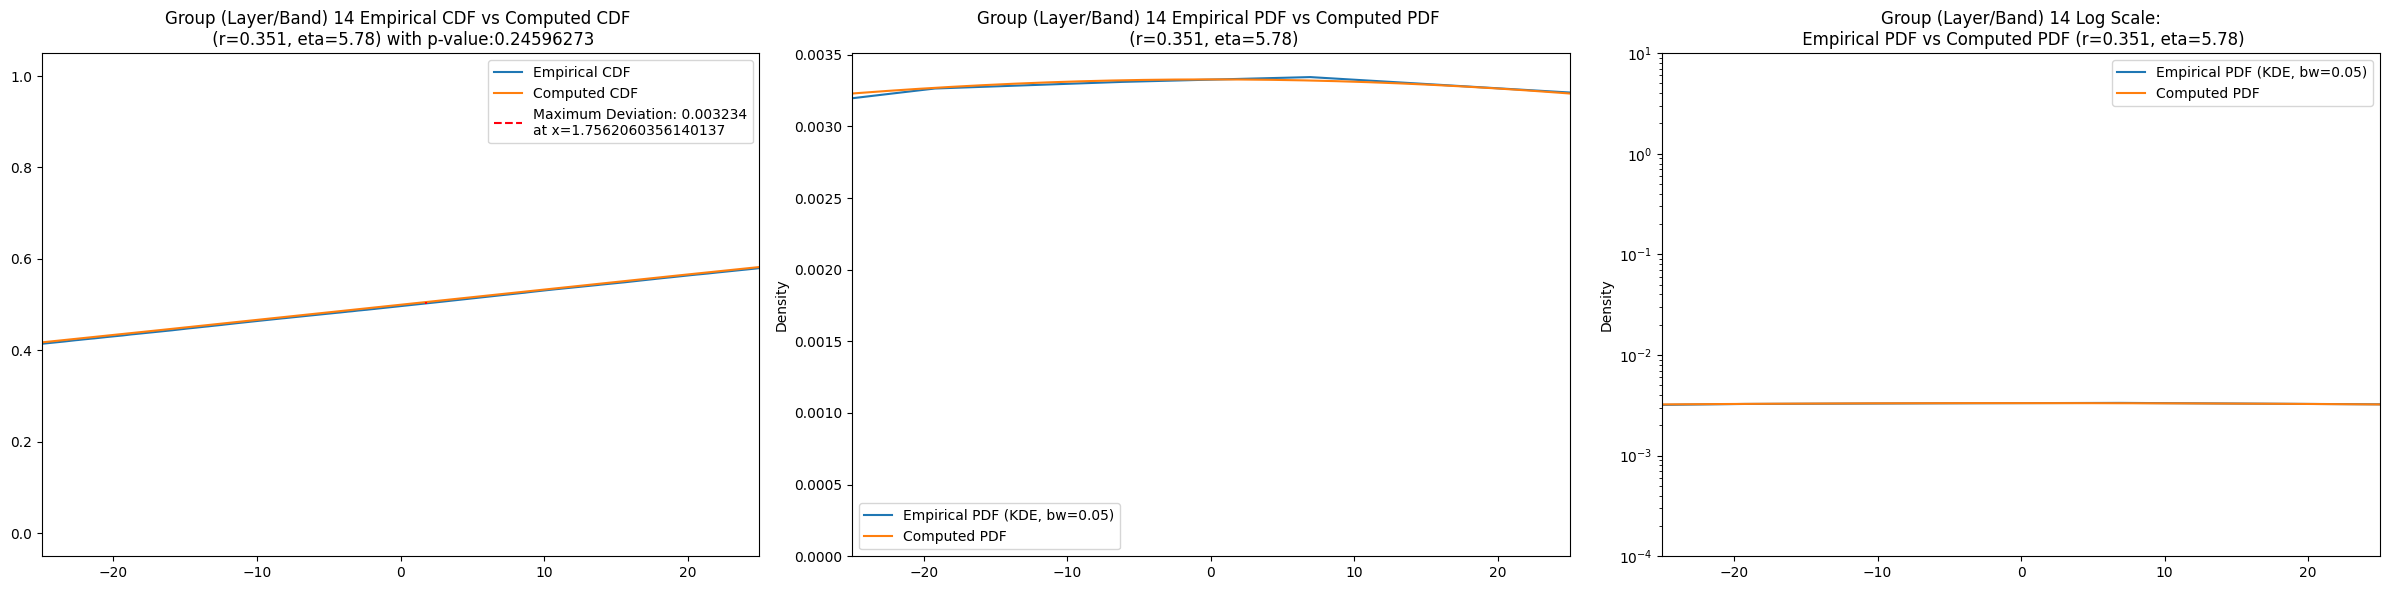

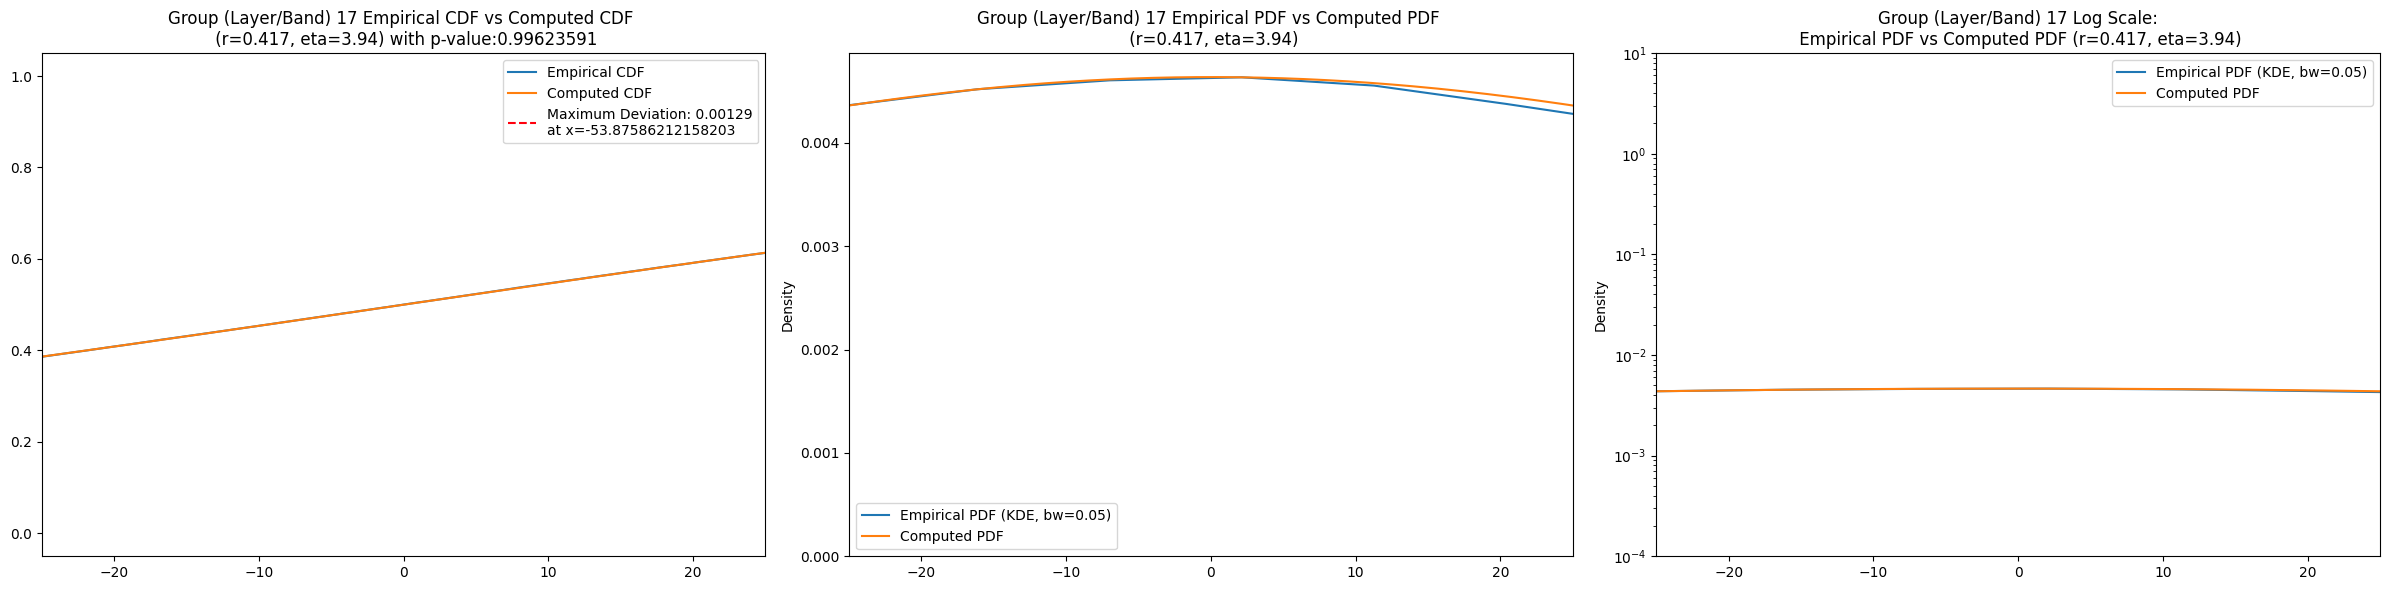

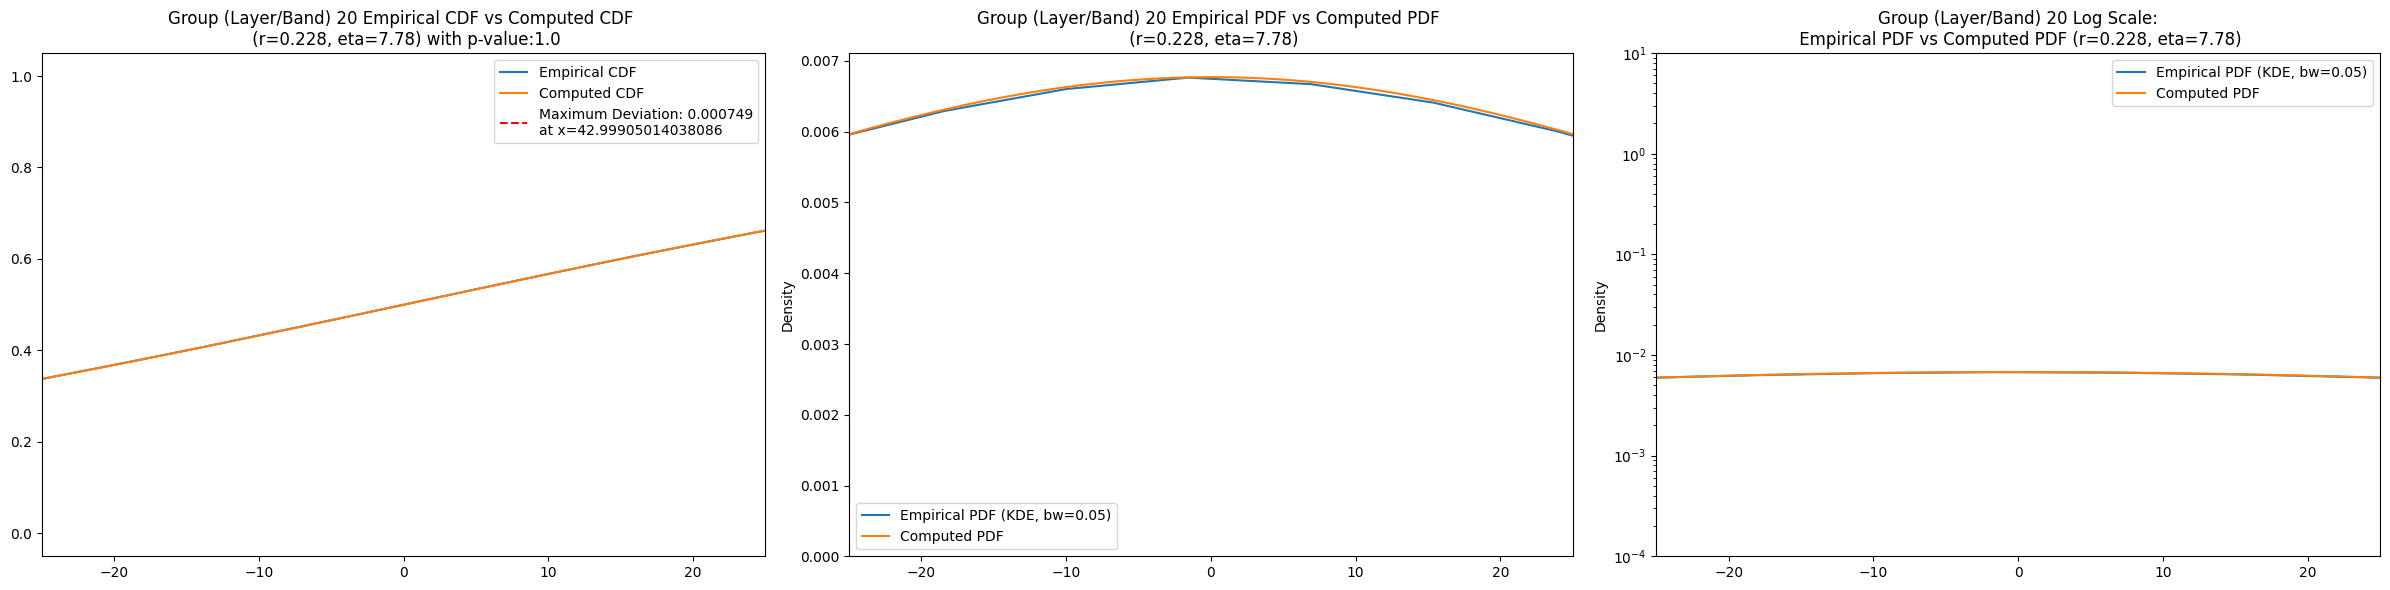

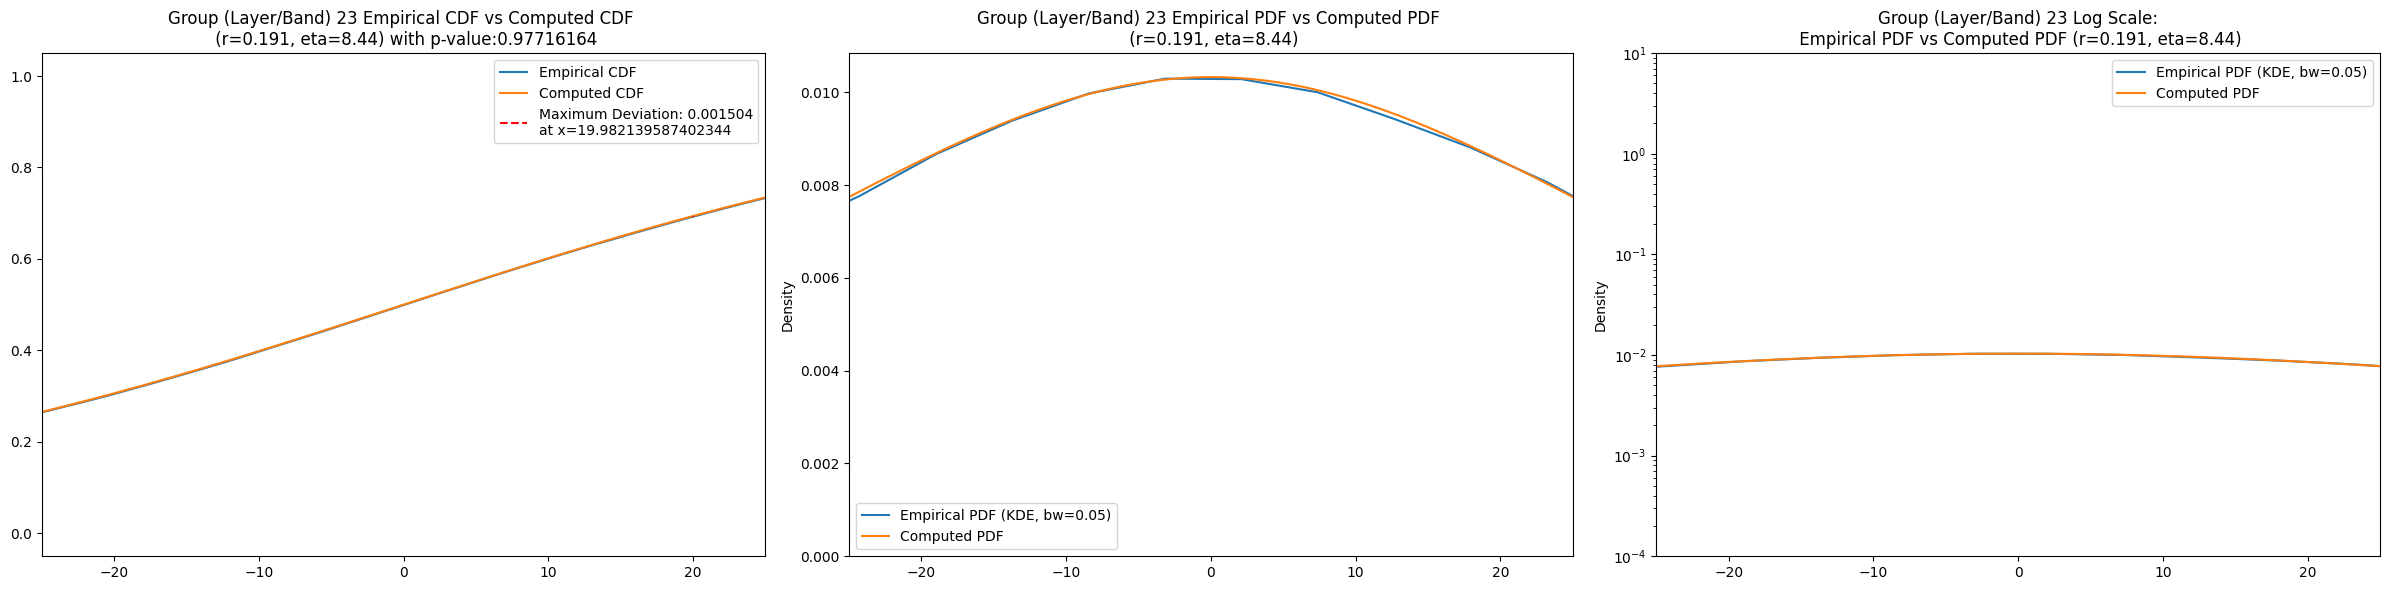

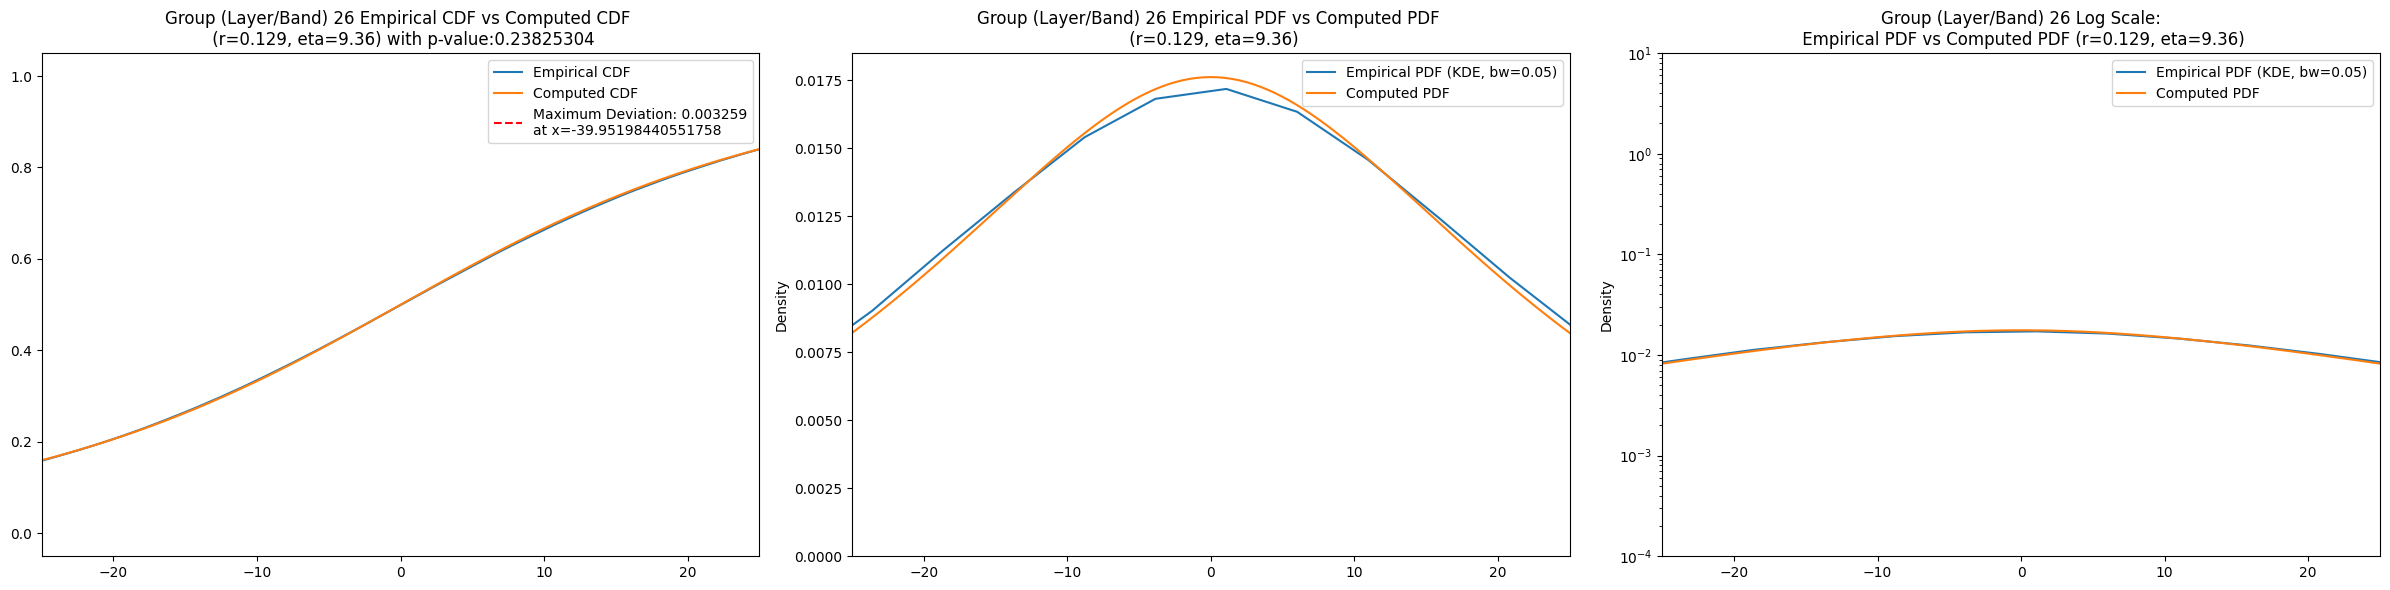

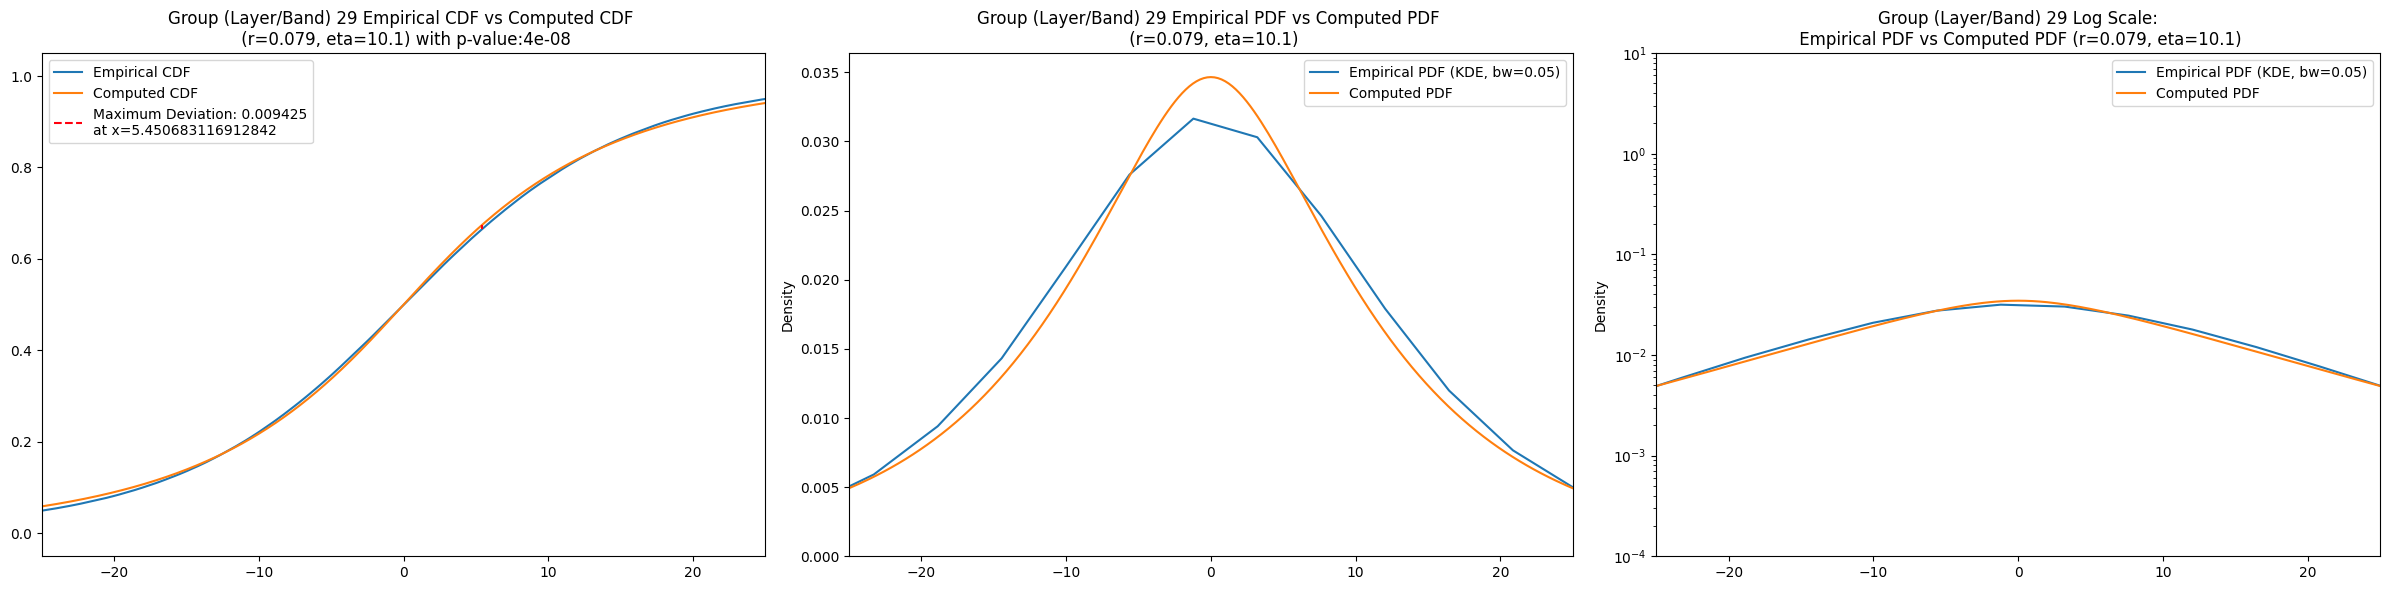

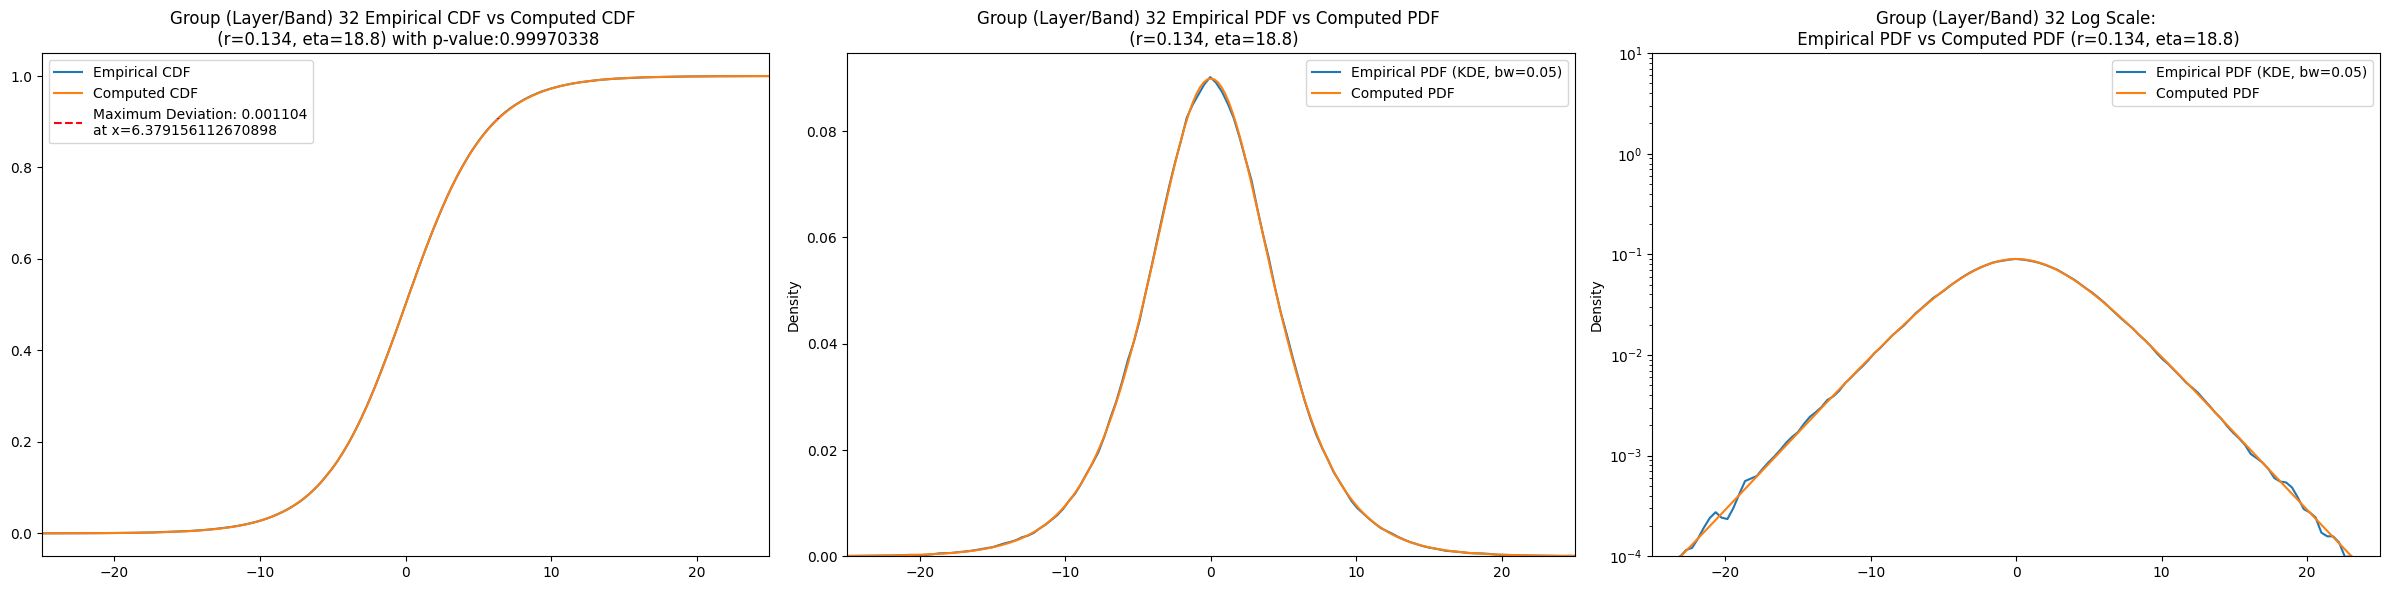

In [12]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [13]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample / np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [14]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
band                                                                       
2     238621.340000  227525.050000  250164.660000   1.329861    0.962390   
5     125861.800000  119992.660000  131988.280000   1.392025    0.909872   
8      66732.330000   63640.670000   69916.100000   1.377129    0.967720   
11     36748.125000   34953.164000   38624.617000   1.727334    1.042835   
14     19290.611000   18380.465000   20250.715000   1.563712    0.985900   
17     10338.449000    9839.270500   10859.774000   1.652823    1.062084   
20      4938.306600    4692.662600    5208.717000   2.060602    1.170981   
23      2210.008000    2095.980200    2333.351800   2.336577    1.422220   
26       871.890900     814.146850     942.188800   5.787819    2.479208   
29       297.936550     265.633850     344.980260  23.688461    6.687737   
32        25.905695      24.708324      27.137707   1.305109    0.893868   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
band                                                                    ...   
2       1.772640        31800.0       0.26          8.0   2.013616e-01  ...   
5       2.123118        41340.0       0.13         19.0   1.329917e-12  ...   
8       1.917665        66780.0       1.04          1.2   2.684428e+04  ...   
11      3.028584       104940.0       0.17         13.0   1.365409e-07  ...   
14      3.021425       162180.0       0.35          5.8   2.902545e+00  ...   
17      3.063314       257580.0       0.42          3.9   2.092382e+01  ...   
20      6.707925       381600.0       0.23          7.7   4.482306e-04  ...   
23      4.876342       610560.0       0.19          8.5   1.567844e-06  ...   
26     17.814651       973080.0       0.13          9.3   1.107631e-12  ...   
29     80.945920      1376940.0       0.08         10.0   1.961918e-25  ...   
32      2.017627       419760.0       0.14         18.0   1.077541e-14  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2          449.75200              0.012827          5.659340e-05   
5          329.40400              0.011148          6.847290e-05   
8          240.13000              0.011126          1.311550e-07   
11         177.45600              0.010774          5.217670e-11   
14         128.36300              0.011347          1.449390e-18   
17          93.38510              0.012076          4.664020e-33   
20          64.31750              0.012115          4.432560e-49   
23          42.33970              0.013545          9.873360e-98   
26          25.70930              0.014893         6.485280e-188   
29          13.89500              0.015675         2.715310e-294   
32           4.75715              0.010036          3.728380e-37   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         402.25900             0.020702         2.855970e-12  323.28900   
5         291.58300             0.020432         2.013390e-15  235.68800   
8         212.18800             0.020464         1.005460e-24  170.83200   
11        155.97800             0.019089         1.197140e-33  126.04000   
14        114.00400             0.020163         1.049040e-57   91.79460   
17         82.63880             0.018304         2.140390e-75   66.56910   
20         56.59070             0.017516        3.931640e-102   45.63660   
23         37.49960             0.017112        1.002810e-155   30.28910   
26         22.65200             0.015655        1.356060e-207   18.29240   
29         12.21400             0.015588        4.820370e-291    9.91920   
32          4.18768             0.020066        2.989110e-147    3.38255   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2  

## Results

In [15]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [16]:
master_df

obs_var      var_lower      var_upper   obs_kurt  kurt_lower  \
band                                                                       
2     238621.340000  227525.050000  250164.660000   1.329861    0.962390   
5     125861.800000  119992.660000  131988.280000   1.392025    0.909872   
8      66732.330000   63640.670000   69916.100000   1.377129    0.967720   
11     36748.125000   34953.164000   38624.617000   1.727334    1.042835   
14     19290.611000   18380.465000   20250.715000   1.563712    0.985900   
17     10338.449000    9839.270500   10859.774000   1.652823    1.062084   
20      4938.306600    4692.662600    5208.717000   2.060602    1.170981   
23      2210.008000    2095.980200    2333.351800   2.336577    1.422220   
26       871.890900     814.146850     942.188800   5.787819    2.479208   
29       297.936550     265.633850     344.980260  23.688461    6.687737   
32        25.905695      24.708324      27.137707   1.305109    0.893868   

      kurt_upper  total_samples  initial_r  initial_eta  initial_scale  ...  \
band                                                                    ...   
2       1.772640        31800.0       0.26          8.0   2.013616e-01  ...   
5       2.123118        41340.0       0.13         19.0   1.329917e-12  ...   
8       1.917665        66780.0       1.04          1.2   2.684428e+04  ...   
11      3.028584       104940.0       0.17         13.0   1.365409e-07  ...   
14      3.021425       162180.0       0.35          5.8   2.902545e+00  ...   
17      3.063314       257580.0       0.42          3.9   2.092382e+01  ...   
20      6.707925       381600.0       0.23          7.7   4.482306e-04  ...   
23      4.876342       610560.0       0.19          8.5   1.567844e-06  ...   
26     17.814651       973080.0       0.13          9.3   1.107631e-12  ...   
29     80.945920      1376940.0       0.08         10.0   1.961918e-25  ...   
32      2.017627       419760.0       0.14         18.0   1.077541e-14  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2          449.75200              0.012827          5.659340e-05   
5          329.40400              0.011148          6.847290e-05   
8          240.13000              0.011126          1.311550e-07   
11         177.45600              0.010774          5.217670e-11   
14         128.36300              0.011347          1.449390e-18   
17          93.38510              0.012076          4.664020e-33   
20          64.31750              0.012115          4.432560e-49   
23          42.33970              0.013545          9.873360e-98   
26          25.70930              0.014893         6.485280e-188   
29          13.89500              0.015675         2.715310e-294   
32           4.75715              0.010036          3.728380e-37   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         402.25900             0.020702         2.855970e-12  323.28900   
5         291.58300             0.020432         2.013390e-15  235.68800   
8         212.18800             0.020464         1.005460e-24  170.83200   
11        155.97800             0.019089         1.197140e-33  126.04000   
14        114.00400             0.020163         1.049040e-57   91.79460   
17         82.63880             0.018304         2.140390e-75   66.56910   
20         56.59070             0.017516        3.931640e-102   45.63660   
23         37.49960             0.017112        1.002810e-155   30.28910   
26         22.65200             0.015655        1.356060e-207   18.29240   
29         12.21400             0.015588        4.820370e-291    9.91920   
32          4.18768             0.020066        2.989110e-147    3.38255   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2  

In [17]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))